## Initialisation

In [25]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')


Project path set to: c:\Github\ode-biomarker-project


In [26]:
from PathLoader import PathLoader
path_loader = PathLoader('data_config.env', 'current_user.env')

In [27]:
from DataLink import DataLink
data_link = DataLink(path_loader, 'data_codes.csv')

In [28]:
folder_name = "ThesisResult3-BenchmarkingExpressionData"
exp_id = "v1"

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

### Load in Palbociclib datasets

In [29]:
# create a joint dataframe of cdk4 expression and drug response for palbociclib
# load in original ccle data
loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(loading_code)

print(f'Proteomic feature data shape: {proteomic_feature_data.shape}', f'Proteomic label data shape: {proteomic_label_data.shape}')

loading_code = "ccle-gdsc-2-Palbociclib-LN_IC50"
ccle_feature_data, ccle_label_data = data_link.get_data_using_code(loading_code)

print(f'CCLE feature data shape: {ccle_feature_data.shape}', f'CCLE label data shape: {ccle_label_data.shape}')

Proteomic feature data shape: (737, 6692) Proteomic label data shape: (737,)
CCLE feature data shape: (584, 19221) CCLE label data shape: (584,)


## Functions 

### Random Forest F-Regression

In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from toolkit import Powerkit, FirstQuantileImputer, select_stat_features


def pipeline_rf_freg(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    rng: int,
    k: int = 50,
    rf_kwargs: dict | None = None,
):
    # 1) Fit transformer(s) on X_train only
    imputer = FirstQuantileImputer().fit(X_train)
    X_train_imp = imputer.transform(X_train, return_df=True)

    # 2) Select features on X_train only
    selected_features, sel_train = select_stat_features(
        X_train_imp, y_train, selection_size=k
    )

    # 3) Train model
    rf_kwargs = rf_kwargs or {}
    model = RandomForestRegressor(random_state=rng, **rf_kwargs)
    model.fit(sel_train, y_train)

    # 4) Return components needed by eval
    return {
        "imputer": imputer,
        "selected_features": list(selected_features),
        "model": model,
    }


def eval_regression(
    X_test: pd.DataFrame,
    y_test: pd.Series,
    *,
    pipeline_components: dict,
    metric: str = "r2",
):
    # Unpack
    imputer = pipeline_components["imputer"]
    selected = pipeline_components["selected_features"]
    model = pipeline_components["model"]

    # Transform test
    X_test_imp = imputer.transform(X_test, return_df=True)
    X_test_sel = X_test_imp[selected]

    # Predict
    y_pred = model.predict(X_test_sel)

    # Metric
    if metric == "r2":
        perf = r2_score(y_test, y_pred)
    else:
        # Extend as needed (pearson, mse, etc.)
        from scipy.stats import pearsonr

        perf = pearsonr(y_test, y_pred)[0]

    # Feature importance tuple: (feature_names, scores)
    if hasattr(model, "feature_importances_"):
        fi = (np.array(selected), model.feature_importances_)
    else:
        # Fallback if model has no built-in importances
        fi = (np.array(selected), np.zeros(len(selected)))

    return {
        "feature_importance": fi,
        "model_performance": perf,
        # Optional: include other artifacts if desired
        "y_pred": y_pred,
    }

### Expression Data Benchmarking Pipe

In [7]:
from typing import Dict, List, Literal
import numpy as np # noqa: F811
import pandas as pd

from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score # noqa: F811
from sklearn.dummy import DummyRegressor

from toolkit import FirstQuantileImputer, f_regression_select, get_model_from_string  # noqa: F811


def _drop_correlated_columns(X: pd.DataFrame, threshold: float = 0.95) -> List[str]:
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = set()
    for col in sorted(upper.columns):
        if col in to_drop:
            continue
        high_corr = upper.index[upper[col] > threshold].tolist()
        to_drop.update(high_corr)
    return [c for c in X.columns if c not in to_drop]

def _drop_correlated_columns_memory_efficient_optimized(X: pd.DataFrame, threshold: float = 0.95) -> List[str]:
    n_features = X.shape[1]
    to_drop = set()
    kept_columns = set()  # Track columns we're keeping
    
    batch_size = 1000
    
    for i in range(0, n_features, batch_size):
        end_idx = min(i + batch_size, n_features)
        batch_cols = X.columns[i:end_idx]
        
        # Calculate correlation for current batch against ALL kept columns
        if kept_columns:
            corr_batch = X[batch_cols].corrwith(X[list(kept_columns)], axis=0).abs()
        else:
            corr_batch = pd.DataFrame(index=batch_cols, columns=[])
        
        for j, col in enumerate(batch_cols):
            if col in to_drop:
                continue
            
            # Check if correlated with any kept columns
            should_drop = False
            if kept_columns:
                max_corr = corr_batch.loc[col].max() if col in corr_batch.index else 0
                if max_corr > threshold:
                    should_drop = True
            
            if should_drop:
                to_drop.add(col)
            else:
                kept_columns.add(col)
    
    return list(kept_columns)

def adaptive_drop_correlated(X, threshold=0.95):
    if X.shape[1] < 5000:
        return _drop_correlated_columns(X, threshold)  # Original
    else:
        return _drop_correlated_columns_memory_efficient_optimized(X, threshold)


def baseline_pipeline(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    rng: int,
    *,
    k: int = 500,
    var_threshold: float = 0.0,
    corr_threshold: float = 0.95,
    model_name: Literal[
        "LinearRegression",
        "RandomForestRegressor",
        "SVR",
        "KNeighborsRegressor",
        "XGBRegressor",
    ] = "LinearRegression",
) -> Dict:
    # 0) Sanitize inputs
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    y_train = pd.Series(y_train).replace([np.inf, -np.inf], np.nan)
    mask = ~y_train.isna()
    X_train, y_train = X_train.loc[mask], y_train.loc[mask]

    # 1) Impute on train (ensure no residual NaNs)
    imputer = FirstQuantileImputer().fit(X_train)
    Xtr = imputer.transform(X_train, return_df=True).astype(float)
    Xtr = Xtr.fillna(0.0)

    # 2) Variance filter
    n_features_initial = Xtr.shape[1]
    vt = VarianceThreshold(threshold=var_threshold).fit(Xtr)
    vt_keep_cols = Xtr.columns[vt.get_support()].tolist()
    Xtr = Xtr[vt_keep_cols]
    n_features_post_variance = Xtr.shape[1]

    # 3) Correlation filter
    corr_keep_cols = adaptive_drop_correlated(Xtr, threshold=corr_threshold)
    Xtr = Xtr[corr_keep_cols]
    n_features_post_correlation = Xtr.shape[1]

    # 4) Univariate ANOVA F-test (fixed top-k)
    k_sel = min(k, Xtr.shape[1]) if Xtr.shape[1] > 0 else 0
    if k_sel == 0:
        selected_features, selector_scores = [], np.array([])
        sel_train = Xtr.iloc[:, :0]
        no_features = True
    else:
        selected_features, selector_scores = f_regression_select(Xtr, y_train, k=k_sel)
        sel_train = Xtr[selected_features]
        no_features = False

    # 5) Fixed model; robust fallback if no features
    if no_features:
        model = DummyRegressor(strategy="mean")
        model.fit(np.zeros((len(y_train), 1)), y_train)
        model_type = "DummyRegressor(mean)"
        model_params = {"strategy": "mean"}
    else:
        if model_name == "LinearRegression":
            model = get_model_from_string("LinearRegression")
        elif model_name == "RandomForestRegressor":
            model = get_model_from_string(
                "RandomForestRegressor", n_estimators=100, random_state=rng
            )
        elif model_name == "SVR":
            model = get_model_from_string("SVR", kernel="linear", C=1.0)
        elif model_name == "KNeighborsRegressor":
            model = get_model_from_string(
                "KNeighborsRegressor", n_neighbors=5, weights="distance", p=2
            )
        elif model_name == "XGBRegressor":
            model = get_model_from_string(
                "XGBRegressor",
                n_estimators=200,
                learning_rate=0.1,
                max_depth=6,
                subsample=1.0,
                colsample_bytree=1.0,
                random_state=rng,
            )
        else:
            raise ValueError("Unsupported model_name for baseline benchmarking.")
        model.fit(sel_train, y_train)
        model_type = model_name
        try:
            model_params = model.get_params(deep=False)
        except Exception:
            model_params = {}

    return {
        "imputer": imputer,
        "vt_keep_cols": vt_keep_cols,
        "corr_keep_cols": corr_keep_cols,
        "selected_features": list(selected_features),
        "selector_scores": np.array(selector_scores),
        "k_requested": int(k),
        "k_effective": int(len(selected_features)),
        "n_features_initial": int(n_features_initial),
        "n_features_post_variance": int(n_features_post_variance),
        "n_features_post_correlation": int(n_features_post_correlation),
        "var_threshold": float(var_threshold),
        "corr_threshold": float(corr_threshold),
        "model": model,
        "model_type": model_type,
        "model_params": model_params,
        "train_data": sel_train,  # may be empty if no_features
        "rng": int(rng),
        "no_features": bool(no_features),
        "n_train_samples_used": int(len(y_train)),
    }


def baseline_eval(
    X_test: pd.DataFrame,
    y_test: pd.Series,
    *,
    pipeline_components: Dict,
    metric_primary: Literal["r2", "pearson_r", "spearman_r"] = "r2",
    importance_from: Literal["selector", "model"] = "selector",
) -> Dict:
    # Unpack
    imputer = pipeline_components["imputer"]
    vt_keep = set(pipeline_components["vt_keep_cols"])
    corr_keep = set(pipeline_components["corr_keep_cols"])
    selected = list(pipeline_components["selected_features"])
    selector_scores = pipeline_components["selector_scores"]
    model = pipeline_components["model"]
    model_name = pipeline_components["model_type"]
    model_params = pipeline_components.get("model_params", {})
    rng = pipeline_components.get("rng", None)
    no_features = pipeline_components.get("no_features", False)

    k_requested = pipeline_components.get("k_requested", len(selected))
    k_effective = pipeline_components.get("k_effective", len(selected))
    n_features_initial = pipeline_components.get("n_features_initial", None)
    n_features_post_variance = pipeline_components.get("n_features_post_variance", None)
    n_features_post_correlation = pipeline_components.get(
        "n_features_post_correlation", None
    )
    var_threshold = pipeline_components.get("var_threshold", None)
    corr_threshold = pipeline_components.get("corr_threshold", None)

    # 0) Sanitize test inputs
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    y_test = pd.Series(y_test).replace([np.inf, -np.inf], np.nan)
    mask_y = ~y_test.isna()
    X_test, y_test = X_test.loc[mask_y], y_test.loc[mask_y]

    # Apply identical transforms
    Xti = imputer.transform(X_test, return_df=True).astype(float).fillna(0.0)
    cols_after_vt = [c for c in Xti.columns if c in vt_keep]
    Xti = Xti[cols_after_vt]
    cols_after_corr = [c for c in Xti.columns if c in corr_keep]
    Xti = Xti[cols_after_corr]
    Xsel = Xti[selected] if len(selected) > 0 else Xti.iloc[:, :0]

    # Predict robustly
    if no_features or Xsel.shape[1] == 0:
        y_pred = np.full_like(
            y_test.values, fill_value=float(y_test.mean()), dtype=float
        )
    else:
        y_pred = np.asarray(model.predict(Xsel), dtype=float)

    # Filter any non-finite values before metrics
    mask_fin = np.isfinite(y_test.values) & np.isfinite(y_pred)
    y_t = y_test.values[mask_fin]
    y_p = y_pred[mask_fin]
    n_test_used = int(y_t.shape[0])

    if n_test_used < 2:
        r2 = np.nan
        pearson_r = pearson_p = np.nan
        spearman_rho = spearman_p = np.nan
    else:
        r2 = r2_score(y_t, y_p)
        pearson_r, pearson_p = pearsonr(y_t, y_p)
        spearman_rho, spearman_p = spearmanr(y_t, y_p)

    metrics = {
        "r2": float(r2) if np.isfinite(r2) else np.nan,
        "pearson_r": float(pearson_r) if np.isfinite(pearson_r) else np.nan,
        "pearson_p": float(pearson_p) if np.isfinite(pearson_p) else np.nan,
        "spearman_rho": float(spearman_rho) if np.isfinite(spearman_rho) else np.nan,
        "spearman_p": float(spearman_p) if np.isfinite(spearman_p) else np.nan,
        "n_test_samples_used": n_test_used,
    }

    # Importance
    if importance_from == "selector":
        fi = (np.array(selected), np.array(selector_scores))
    else:
        if hasattr(model, "feature_importances_") and len(selected) > 0:
            fi = (np.array(selected), model.feature_importances_)
        elif model_name in ("LinearRegression",) and len(selected) > 0:
            coef = getattr(model, "coef_", np.zeros(len(selected)))
            fi = (np.array(selected), np.abs(coef))
        else:
            fi = (np.array(selected), np.zeros(len(selected)))

    primary = metrics.get(metric_primary, metrics["r2"])

    return {
        "feature_importance": fi,
        "feature_importance_from": importance_from,
        "model_performance": float(primary) if primary is not None else np.nan,
        "metrics": metrics,
        "k_requested": int(k_requested),
        "k_effective": int(k_effective),
        "n_features_initial": int(n_features_initial)
        if n_features_initial is not None
        else None,
        "n_features_post_variance": int(n_features_post_variance)
        if n_features_post_variance is not None
        else None,
        "n_features_post_correlation": int(n_features_post_correlation)
        if n_features_post_correlation is not None
        else None,
        "var_threshold": float(var_threshold) if var_threshold is not None else None,
        "corr_threshold": float(corr_threshold) if corr_threshold is not None else None,
        "model_name": model_name,
        "model_params": model_params,
        "rng": rng,
        "selected_features": selected,
        "selector_scores": np.array(selector_scores),
        "y_pred": y_p,  # filtered to finite entries
        "y_true_index": y_test.index[mask_fin],
        "n_train_samples_used": pipeline_components.get("n_train_samples_used", None),
    }


## Execution

### Benchmarking Expression Datasets (k=500)

In [8]:
import numpy as np  # noqa: F811
import pandas as pd
from toolkit import Powerkit  # noqa: F811

# 1) Align indices and order (critical for identical splits across modalities)
common = sorted(
    set(ccle_label_data.index)
    & set(ccle_feature_data.index)
    & set(proteomic_label_data.index)
    & set(proteomic_feature_data.index)
)
ccle_feature_data = ccle_feature_data.loc[common]
ccle_label_data = ccle_label_data.loc[common]
proteomic_feature_data = proteomic_feature_data.loc[common]
proteomic_label_data = proteomic_label_data.loc[common]

# Optional: ensure numeric only
ccle_feature_data = ccle_feature_data.select_dtypes(include=[np.number])
proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])

fixed_args = {"k": 500, "var_threshold": 0.0, "corr_threshold": 0.95}
models = [
    "LinearRegression",
    "RandomForestRegressor",
    "SVR",
]  # extend with "KNeighborsRegressor","XGBRegressor"


def add_baselines(pk: Powerkit, model_list):
    for m in model_list:
        cond = f"baseline_{m.lower().replace('regressor', '')}"
        pk.add_condition(
            condition=cond,
            get_importance=False,  # 3.3.2 focuses on performance; set True if you need FI aggregation
            pipeline_function=baseline_pipeline,
            pipeline_args={**fixed_args, "model_name": m},
            eval_function=baseline_eval,
            eval_args={"metric_primary": "r2", "importance_from": "selector"},
        )


# 2) Build Powerkit instances and register conditions
pk_rna = Powerkit(ccle_feature_data, ccle_label_data)
add_baselines(pk_rna, models)

pk_prot = Powerkit(proteomic_feature_data, proteomic_label_data)
add_baselines(pk_prot, models)

# 3) Identical RNGs for fair repeated holdouts
rngs = np.random.RandomState(42).randint(0, 100000, size=50)

df_rna = pk_rna.run_all_conditions(rng_list=rngs, n_jobs=-1, verbose=True)
df_rna["modality"] = "RNASeq"
df_prot = pk_prot.run_all_conditions(rng_list=rngs, n_jobs=-1, verbose=True)
df_prot["modality"] = "Proteomic"
# 5) Concatenate and summarize
df_all = pd.concat([df_rna, df_prot], ignore_index=True)

# model_performance is primary metric (R2); full metrics dict per row in 'metrics'
summary = (
    df_all.groupby(["modality", "condition"])["model_performance"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
print(summary)


KeyboardInterrupt: 

In [ ]:
from scipy.stats import pearsonr, spearmanr  # noqa: F811

# Expand stored 'metrics' dict (if present) and show pearson/spearman by modality+condition,
# plus an optional recompute from y_true_index + y_pred for verification.

# 1) If df_all contains a 'metrics' column with dicts, unpack it
if "metrics" in df_all.columns and "pearson_r" not in df_all.columns:
    metrics_df = pd.json_normalize(df_all["metrics"])
    for col in ("r2", "pearson_r", "spearman_rho"):
        if col in metrics_df.columns:
            df_all[col] = metrics_df[col]

# 2) Quick grouped summary from stored metrics (if available)
if {"pearson_r", "spearman_rho"}.issubset(df_all.columns):
    print("Stored metrics (mean ± std) by modality and condition:")
    print(
        df_all.groupby(["modality", "condition"])[["pearson_r", "spearman_rho"]]
        .agg(["mean", "std"])
        .round(4)
    )
else:
    print("Stored pearson/spearman not found in df_all; you can recompute them from y_true_index + y_pred (see step 3).")

# 3) Recompute metrics from y_true_index and y_pred to verify (uses ccle_label_data / proteomic_label_data)

def recompute_metrics(row):
    # pick correct label series based on modality
    labels = ccle_label_data if row["modality"] == "RNASeq" else proteomic_label_data
    idx = row["y_true_index"]
    y_true = labels.loc[idx].values
    y_pred = np.asarray(row["y_pred"], dtype=float)

    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() < 2:
        return pd.Series({"r2_re": np.nan, "pearson_r_re": np.nan, "spearman_rho_re": np.nan})

    r2 = r2_score(y_true[mask], y_pred[mask])
    pr = pearsonr(y_true[mask], y_pred[mask])[0]
    sr = spearmanr(y_true[mask], y_pred[mask])[0]
    return pd.Series({"r2_re": r2, "pearson_r_re": pr, "spearman_rho_re": sr})

recomputed = df_all.apply(recompute_metrics, axis=1)
df_all = pd.concat([df_all, recomputed], axis=1)

# print("\nRecomputed metrics (mean ± std) by modality and condition:")
# print(
#     df_all.groupby(["modality", "condition"])[["pearson_r_re", "spearman_rho_re"]]
#     .agg(["mean", "std"])
#     .round(4)
# )

# Optionally inspect row-level values
display_cols = ["modality", "condition", "pearson_r_re", "spearman_rho_re", "r2_re"]
# print("\nPer-row recomputed metrics:")


Stored metrics (mean ± std) by modality and condition:
                                    pearson_r     spearman_rho    
                                         mean std         mean std
modality  condition                                               
Proteomic baseline_linearregression    0.0644 NaN       0.0487 NaN
          baseline_randomforest        0.7172 NaN       0.6623 NaN
          baseline_svr                 0.3184 NaN       0.3376 NaN
RNASeq    baseline_linearregression    0.1578 NaN       0.1762 NaN
          baseline_randomforest        0.7368 NaN       0.7110 NaN
          baseline_svr                 0.2996 NaN       0.2886 NaN


In [ ]:
df_all.to_pickle(f"{file_save_path}benchmarking_results_{exp_id}.pkl")

# Also save the individual modality results
df_rna.to_pickle(f"{file_save_path}rna_results_{exp_id}.pkl")
df_prot.to_pickle(f"{file_save_path}proteomic_results_{exp_id}.pkl")


### Benchmarking Expression Datasets (three k values)

In [ ]:
import numpy as np  # noqa: F811
import pandas as pd
from toolkit import Powerkit  # noqa: F811

# 1) Align indices and order (critical for identical splits across modalities)
common = sorted(
    set(ccle_label_data.index)
    & set(ccle_feature_data.index)
    & set(proteomic_label_data.index)
    & set(proteomic_feature_data.index)
)
ccle_feature_data = ccle_feature_data.loc[common]
ccle_label_data = ccle_label_data.loc[common]
proteomic_feature_data = proteomic_feature_data.loc[common]
proteomic_label_data = proteomic_label_data.loc[common]

# Optional: ensure numeric only
ccle_feature_data = ccle_feature_data.select_dtypes(include=[np.number])
proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])

# Define k values to test
k_values = [20, 100, 500]
fixed_args_base = {"var_threshold": 0.0, "corr_threshold": 0.95}
models = [
    "LinearRegression",
    "RandomForestRegressor",
    "SVR",
]  # extend with "KNeighborsRegressor","XGBRegressor"

def add_baselines(pk: Powerkit, model_list, k_values):
    for m in model_list:
        for k in k_values:
            cond = f"baseline_{m.lower().replace('regressor', '')}_k{k}"
            pk.add_condition(
                condition=cond,
                get_importance=False,  # 3.3.2 focuses on performance; set True if you need FI aggregation
                pipeline_function=baseline_pipeline,
                pipeline_args={**fixed_args_base, "model_name": m, "k": k},
                eval_function=baseline_eval,
                eval_args={"metric_primary": "r2", "importance_from": "selector"},
            )

# 2) Build Powerkit instances and register conditions
pk_rna = Powerkit(ccle_feature_data, ccle_label_data)
add_baselines(pk_rna, models, k_values)
pk_prot = Powerkit(proteomic_feature_data, proteomic_label_data)
add_baselines(pk_prot, models, k_values)

# 3) Identical RNGs for fair repeated holdouts
rngs = np.random.RandomState(42).randint(0, 100000, size=50)


In [ ]:

# 4) Run all conditions
df_rna = pk_rna.run_all_conditions(rng_list=rngs, n_jobs=-1, verbose=True)
df_rna["modality"] = "RNASeq"


In [ ]:

df_prot = pk_prot.run_all_conditions(rng_list=rngs, n_jobs=-1, verbose=True)
df_prot["modality"] = "Proteomic"


In [26]:

# 5) Concatenate and summarize
df_all = pd.concat([df_rna, df_prot], ignore_index=True)

# 6) Extract k value from condition name for grouping
df_all["k_value"] = df_all["condition"].str.extract(r'k(\d+)').astype(int)

# model_performance is primary metric (R2); full metrics dict per row in 'metrics'
summary = (
    df_all.groupby(["modality", "condition", "k_value"])["model_performance"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
print(summary)

     modality                       condition  k_value        mean  std  count
0   Proteomic  baseline_linearregression_k100      100    0.400253  NaN      1
1   Proteomic   baseline_linearregression_k20       20    0.382698  NaN      1
2   Proteomic  baseline_linearregression_k500      500 -200.721790  NaN      1
3   Proteomic      baseline_randomforest_k100      100    0.434101  NaN      1
4   Proteomic       baseline_randomforest_k20       20    0.272204  NaN      1
5   Proteomic      baseline_randomforest_k500      500    0.453106  NaN      1
6   Proteomic               baseline_svr_k100      100    0.279440  NaN      1
7   Proteomic                baseline_svr_k20       20    0.397100  NaN      1
8   Proteomic               baseline_svr_k500      500   -2.178528  NaN      1
9      RNASeq  baseline_linearregression_k100      100    0.291513  NaN      1
10     RNASeq   baseline_linearregression_k20       20    0.474755  NaN      1
11     RNASeq  baseline_linearregression_k500      5

In [ ]:
df_all.to_pickle(f"{file_save_path}benchmarking_results_{exp_id}.pkl")

# Also save the individual modality results
df_rna.to_pickle(f"{file_save_path}rna_results_{exp_id}.pkl")
df_prot.to_pickle(f"{file_save_path}proteomic_results_{exp_id}.pkl")


## Reading data 

This section can be ran to read in the data used for the analysis. The initialisation code block must be run first to load in the correct file paths.

### Data Extraction

In [6]:
import pandas as pd # noqa: F811

# Load benchmark result pickles saved in Execution cells
files = {
    "df_all": f"{file_save_path}benchmarking_results_{exp_id}.pkl",
    "df_rna": f"{file_save_path}rna_results_{exp_id}.pkl",
    "df_prot": f"{file_save_path}proteomic_results_{exp_id}.pkl",
}

_loaded = {}
for varname, filepath in files.items():
    if os.path.exists(filepath):
        try:
            _loaded[varname] = pd.read_pickle(filepath)
            print(f"Loaded {varname} from {filepath} (shape: {_loaded[varname].shape})")
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            _loaded[varname] = None
    else:
        print(f"File not found: {filepath}")
        _loaded[varname] = None

# Assign to notebook variables (may overwrite existing objects)
df_all = _loaded.get("df_all")
df_rna = _loaded.get("df_rna")
df_prot = _loaded.get("df_prot")

Loaded df_all from G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/benchmarking_results_v1.pkl (shape: (1800, 21))
Loaded df_rna from G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/rna_results_v1.pkl (shape: (900, 20))
Loaded df_prot from G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/proteomic_results_v1.pkl (shape: (900, 20))


In [7]:
df_all.describe()

,rng,model_performance,k_requested,k_effective,n_features_initial,n_features_post_variance,n_features_post_correlation,var_threshold,corr_threshold,n_train_samples_used,k_value
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.0,1.800000e+03,1800.0,1800.000000
mean,52368.890000,0.006495,206.666667,206.666667,12956.500000,12892.495000,12892.495000,0.0,9.500000e-01,237.0,206.666667
std,28594.269395,0.415681,210.031894,210.031894,6266.240864,6290.794132,6290.794132,0.0,2.221063e-16,0.0,210.031894
min,769.000000,-2.435213,20.000000,20.000000,6692.000000,6592.000000,6592.000000,0.0,9.500000e-01,237.0,20.000000
25%,27934.250000,-0.205437,20.000000,20.000000,6692.000000,6603.000000,6603.000000,0.0,9.500000e-01,237.0,20.000000
50%,58018.000000,0.119766,100.000000,100.000000,12956.500000,12891.000000,12891.000000,0.0,9.500000e-01,237.0,100.000000
75%,76619.000000,0.304429,500.000000,500.000000,19221.000000,19183.000000,19183.000000,0.0,9.500000e-01,237.0,500.000000
max,99299.000000,0.674384,500.000000,500.000000,19221.000000,19187.000000,19187.000000,0.0,9.500000e-01,237.0,500.000000


In [8]:
import numpy as np  # noqa: F811

# Quick descriptive summary of df_all
# (relies on df_all, np already defined in the notebook)
print("Shape:", df_all.shape)
print("\nColumns and dtypes:")
print(df_all.dtypes)

print("\nMemory usage (MB):", df_all.memory_usage(deep=True).sum() / 1024**2)

print("\nInfo:")
df_all.info(verbose=True)

# Numeric summary
print("\nNumeric summary (describe):")
print(df_all.select_dtypes(include=[np.number]).describe().T)

# Key categorical counts
print("\nModality counts:")
print(df_all['modality'].value_counts())

print("\nTop conditions:")
print(df_all['condition'].value_counts().head(20))

# Show a concise sample of rows focusing on important columns
cols_to_show = ['modality', 'condition', 'model_name', 'k_value', 'rng', 'model_performance']
print("\nSample rows:")
print(df_all[cols_to_show].head(6).to_string(index=False))

# Inspect selected_features length distribution (useful because column holds lists)
def _len_maybe(x):
    try:
        return len(x)
    except Exception:
        return np.nan

sel_len = df_all['selected_features'].apply(_len_maybe)
print("\nselected_features length (count, mean, std, min, max):")
print(sel_len.describe())

# Missingness overview (top 20)
print("\nMissing values per column (top 20):")
print(df_all.isna().sum().sort_values(ascending=False).head(20))

Shape: (1800, 21)

Columns and dtypes:
rng                              int64
condition                       object
feature_importance_from         object
model_performance              float64
metrics                         object
k_requested                      int64
k_effective                      int64
n_features_initial               int64
n_features_post_variance         int64
n_features_post_correlation      int64
var_threshold                  float64
corr_threshold                 float64
model_name                      object
model_params                    object
selected_features               object
selector_scores                 object
y_pred                          object
y_true_index                    object
n_train_samples_used             int64
modality                        object
k_value                          int64
dtype: object

Memory usage (MB): 8.370616912841797

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data colu

### Statistical tests

#### Best vs worst for each dataset

In [9]:
# Group by modality, model, and k-value to find performance extremes
performance_summary = (
    df_all.groupby(["modality", "model_name", "k_value"])["model_performance"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# Find best and worst for each modality
best_per_modality = performance_summary.loc[
    performance_summary.groupby("modality")["mean"].idxmax()
]

worst_per_modality = performance_summary.loc[
    performance_summary.groupby("modality")["mean"].idxmin()
]

print("Best performing combinations by modality:")
print(best_per_modality)

print("\nWorst performing combinations by modality:")
print(worst_per_modality)


Best performing combinations by modality:
     modality             model_name  k_value      mean       std  count
5   Proteomic  RandomForestRegressor      500  0.323797  0.149243    100
14     RNASeq  RandomForestRegressor      500  0.319569  0.147476    100

Worst performing combinations by modality:
     modality        model_name  k_value      mean       std  count
2   Proteomic  LinearRegression      500 -0.565624  0.517308    100
16     RNASeq               SVR      100 -0.379492  0.469953    100


In [10]:
# Extract the actual performance data for best and worst combinations
def extract_comparison_data(df, modality, model, k_value):
    """Extract all performance values for a specific combination"""
    return df[
        (df["modality"] == modality)
        & (df["model_name"] == model)
        & (df["k_value"] == k_value)
    ]["model_performance"].values


# Best combinations comparison
rna_best_data = extract_comparison_data(
    df_all, "RNASeq", "RandomForestRegressor", 500
)  # From your results [1]
prot_best_data = extract_comparison_data(
    df_all, "Proteomic", "RandomForestRegressor", 500
)  # From your results [1]

# Worst combinations comparison
rna_worst_data = extract_comparison_data(
    df_all, "RNASeq", "SVR", 100
)  # Example: worst RNASeq [1]
prot_worst_data = extract_comparison_data(
    df_all, "Proteomic", "LinearRegression", 500
)  # Example: worst Proteomic [1]


In [11]:
from scipy.stats import ttest_ind, mannwhitneyu

# Compare best RNASeq vs best Proteomic
print("=== STATISTICAL COMPARISON: BEST PERFORMERS ===")

# T-test for parametric comparison
t_stat_best, p_val_ttest_best = ttest_ind(
    rna_best_data, prot_best_data, nan_policy="omit"
)
print(f"T-test: t-statistic = {t_stat_best:.4f}, p-value = {p_val_ttest_best:.4f}")

# Mann-Whitney U test for non-parametric comparison
u_stat_best, p_val_mw_best = mannwhitneyu(
    rna_best_data, prot_best_data, nan_policy="omit"
)
print(f"Mann-Whitney U: statistic = {u_stat_best:.4f}, p-value = {p_val_mw_best:.4f}")

# Effect size and practical significance
mean_diff_best = rna_best_data.mean() - prot_best_data.mean()
print(f"Mean difference (RNASeq - Proteomic): {mean_diff_best:.4f}")
print(f"RNASeq best mean: {rna_best_data.mean():.4f}")
print(f"Proteomic best mean: {prot_best_data.mean():.4f}")

rna_best_max = rna_best_data.max()
prot_best_max = prot_best_data.max()
rna_best_min = rna_best_data.min()
prot_best_min = prot_best_data.min()

print(f"RNASeq best max: {rna_best_max:.4f}, min: {rna_best_min:.4f}")
print(f"Proteomic best max: {prot_best_max:.4f}, min: {prot_best_min:.4f}")

=== STATISTICAL COMPARISON: BEST PERFORMERS ===
T-test: t-statistic = -0.2015, p-value = 0.8405
Mann-Whitney U: statistic = 4860.0000, p-value = 0.7332
Mean difference (RNASeq - Proteomic): -0.0042
RNASeq best mean: 0.3196
Proteomic best mean: 0.3238
RNASeq best max: 0.6744, min: -0.2322
Proteomic best max: 0.6172, min: -0.1495


In [12]:
print("\n=== STATISTICAL COMPARISON: WORST PERFORMERS ===")

# T-test for worst performers
t_stat_worst, p_val_ttest_worst = ttest_ind(
    rna_worst_data, prot_worst_data, nan_policy="omit"
)
print(f"T-test: t-statistic = {t_stat_worst:.4f}, p-value = {p_val_ttest_worst:.4f}")

# Mann-Whitney U test for worst performers
u_stat_worst, p_val_mw_worst = mannwhitneyu(
    rna_worst_data, prot_worst_data, nan_policy="omit"
)
print(f"Mann-Whitney U: statistic = {u_stat_worst:.4f}, p-value = {p_val_mw_worst:.4f}")

# Effect size for worst performers
mean_diff_worst = rna_worst_data.mean() - prot_worst_data.mean()
print(f"Mean difference (RNASeq - Proteomic): {mean_diff_worst:.4f}")



=== STATISTICAL COMPARISON: WORST PERFORMERS ===
T-test: t-statistic = 2.6632, p-value = 0.0084
Mann-Whitney U: statistic = 6211.0000, p-value = 0.0031
Mean difference (RNASeq - Proteomic): 0.1861


### RNASeq Data

In [13]:
# Filter for RNASeq data only
df_rna_only = df_all[df_all["modality"] == "RNASeq"]

# Group by model and k-value to compare performance
model_performance_rna = (
    df_rna_only.groupby(["model_name", "k_value"])["model_performance"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

print("RNASeq Performance by Model Type:")
print(model_performance_rna.round(4))


RNASeq Performance by Model Type:
              model_name  k_value    mean     std  count
0       LinearRegression       20  0.2499  0.1976    100
1       LinearRegression      100 -0.2568  0.4167    100
2       LinearRegression      500 -0.3395  0.3360    100
3  RandomForestRegressor       20  0.2810  0.1706    100
4  RandomForestRegressor      100  0.2913  0.1657    100
5  RandomForestRegressor      500  0.3196  0.1475    100
6                    SVR       20  0.2004  0.2016    100
7                    SVR      100 -0.3795  0.4700    100
8                    SVR      500 -0.1131  0.2767    100


Saved figure to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/boxplot_overall_performance_v1.png


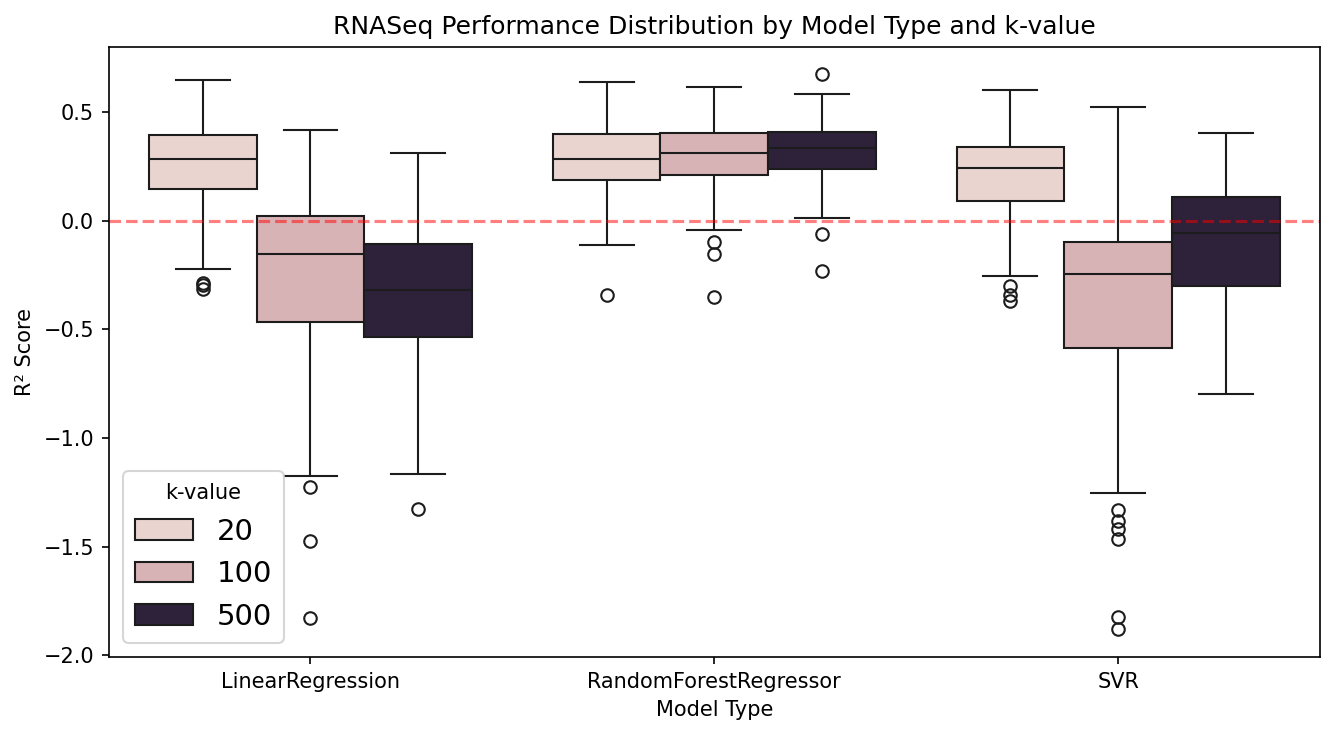

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Your plotting code
plt.figure(figsize=(9, 5), dpi=150)
sns.boxplot(data=df_rna_only, x="model_name", y="model_performance", hue="k_value")
plt.title("RNASeq Performance Distribution by Model Type and k-value")
plt.ylabel("R² Score")
plt.xlabel("Model Type")
plt.axhline(y=0, color="red", linestyle="--", alpha=0.5)
plt.legend(title="k-value", fontsize=14)
plt.tight_layout()

# Save the figure
os.makedirs(file_save_path, exist_ok=True)
fname = os.path.join(file_save_path, f"boxplot_overall_performance_{exp_id}.png")

# Explicitly save the current figure
plt.savefig(fname, dpi=300, bbox_inches="tight")
print(f"Saved figure to: {fname}")

plt.show()
# Close the figure to free memory
plt.close()


In [16]:
from scipy.stats import f_oneway, kruskal

# Extract performance data for each model
models = df_rna_only["model_name"].unique()
model_data = {}
for model in models:
    model_data[model] = df_rna_only[df_rna_only["model_name"] == model][
        "model_performance"
    ].values

# ANOVA test for parametric comparison
f_stat, p_val_anova = f_oneway(*[model_data[model] for model in models])
print(f"ANOVA across models: F-statistic = {f_stat:.4f}, p-value = {p_val_anova:.4f}")

# Kruskal-Wallis test for non-parametric comparison
h_stat, p_val_kw = kruskal(*[model_data[model] for model in models])
print(
    f"Kruskal-Wallis across models: H-statistic = {h_stat:.4f}, p-value = {p_val_kw:.4f}"
)


ANOVA across models: F-statistic = 132.2104, p-value = 0.0000
Kruskal-Wallis across models: H-statistic = 257.1284, p-value = 0.0000


In [17]:
# Comprehensive RNASeq analysis
rna_analysis = (
    df_rna_only.groupby(["model_name", "k_value"])["model_performance"]
    .agg(
        [
            ("mean_r2", "mean"),
            ("std_r2", "std"),
            ("median_r2", "median"),
            ("min_r2", "min"),
            ("max_r2", "max"),
            ("count", "count"),
        ]
    )
    .round(4)
)

print("Detailed RNASeq Performance Analysis:")
print(rna_analysis)

# Find best performing model for RNASeq
best_rna_model = rna_analysis["mean_r2"].idxmax()
best_rna_performance = rna_analysis["mean_r2"].max()
print(f"\nBest RNASeq model: {best_rna_model} with R² = {best_rna_performance:.4f}")


Detailed RNASeq Performance Analysis:
                               mean_r2  std_r2  median_r2  min_r2  max_r2  \
model_name            k_value                                               
LinearRegression      20        0.2499  0.1976     0.2861 -0.3164  0.6492   
                      100      -0.2568  0.4167    -0.1510 -1.8308  0.4188   
                      500      -0.3395  0.3360    -0.3198 -1.3282  0.3138   
RandomForestRegressor 20        0.2810  0.1706     0.2823 -0.3398  0.6379   
                      100       0.2913  0.1657     0.3128 -0.3524  0.6157   
                      500       0.3196  0.1475     0.3357 -0.2322  0.6744   
SVR                   20        0.2004  0.2016     0.2431 -0.3680  0.5997   
                      100      -0.3795  0.4700    -0.2460 -1.8811  0.5227   
                      500      -0.1131  0.2767    -0.0547 -0.7960  0.4052   

                               count  
model_name            k_value         
LinearRegression      20         100

In [18]:
# Compare how each model performs with different feature selection sizes
k_value_comparison = df_rna_only.pivot_table(
    index="model_name", columns="k_value", values="model_performance", aggfunc="mean"
).round(4)

print("RNASeq Model Performance by k-value:")
print(k_value_comparison)


RNASeq Model Performance by k-value:
k_value                   20      100     500
model_name                                   
LinearRegression       0.2499 -0.2568 -0.3395
RandomForestRegressor  0.2810  0.2913  0.3196
SVR                    0.2004 -0.3795 -0.1131


### Heatmaps

#### General heatmap

Saved figure to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/heatmap_performance_comparison.png


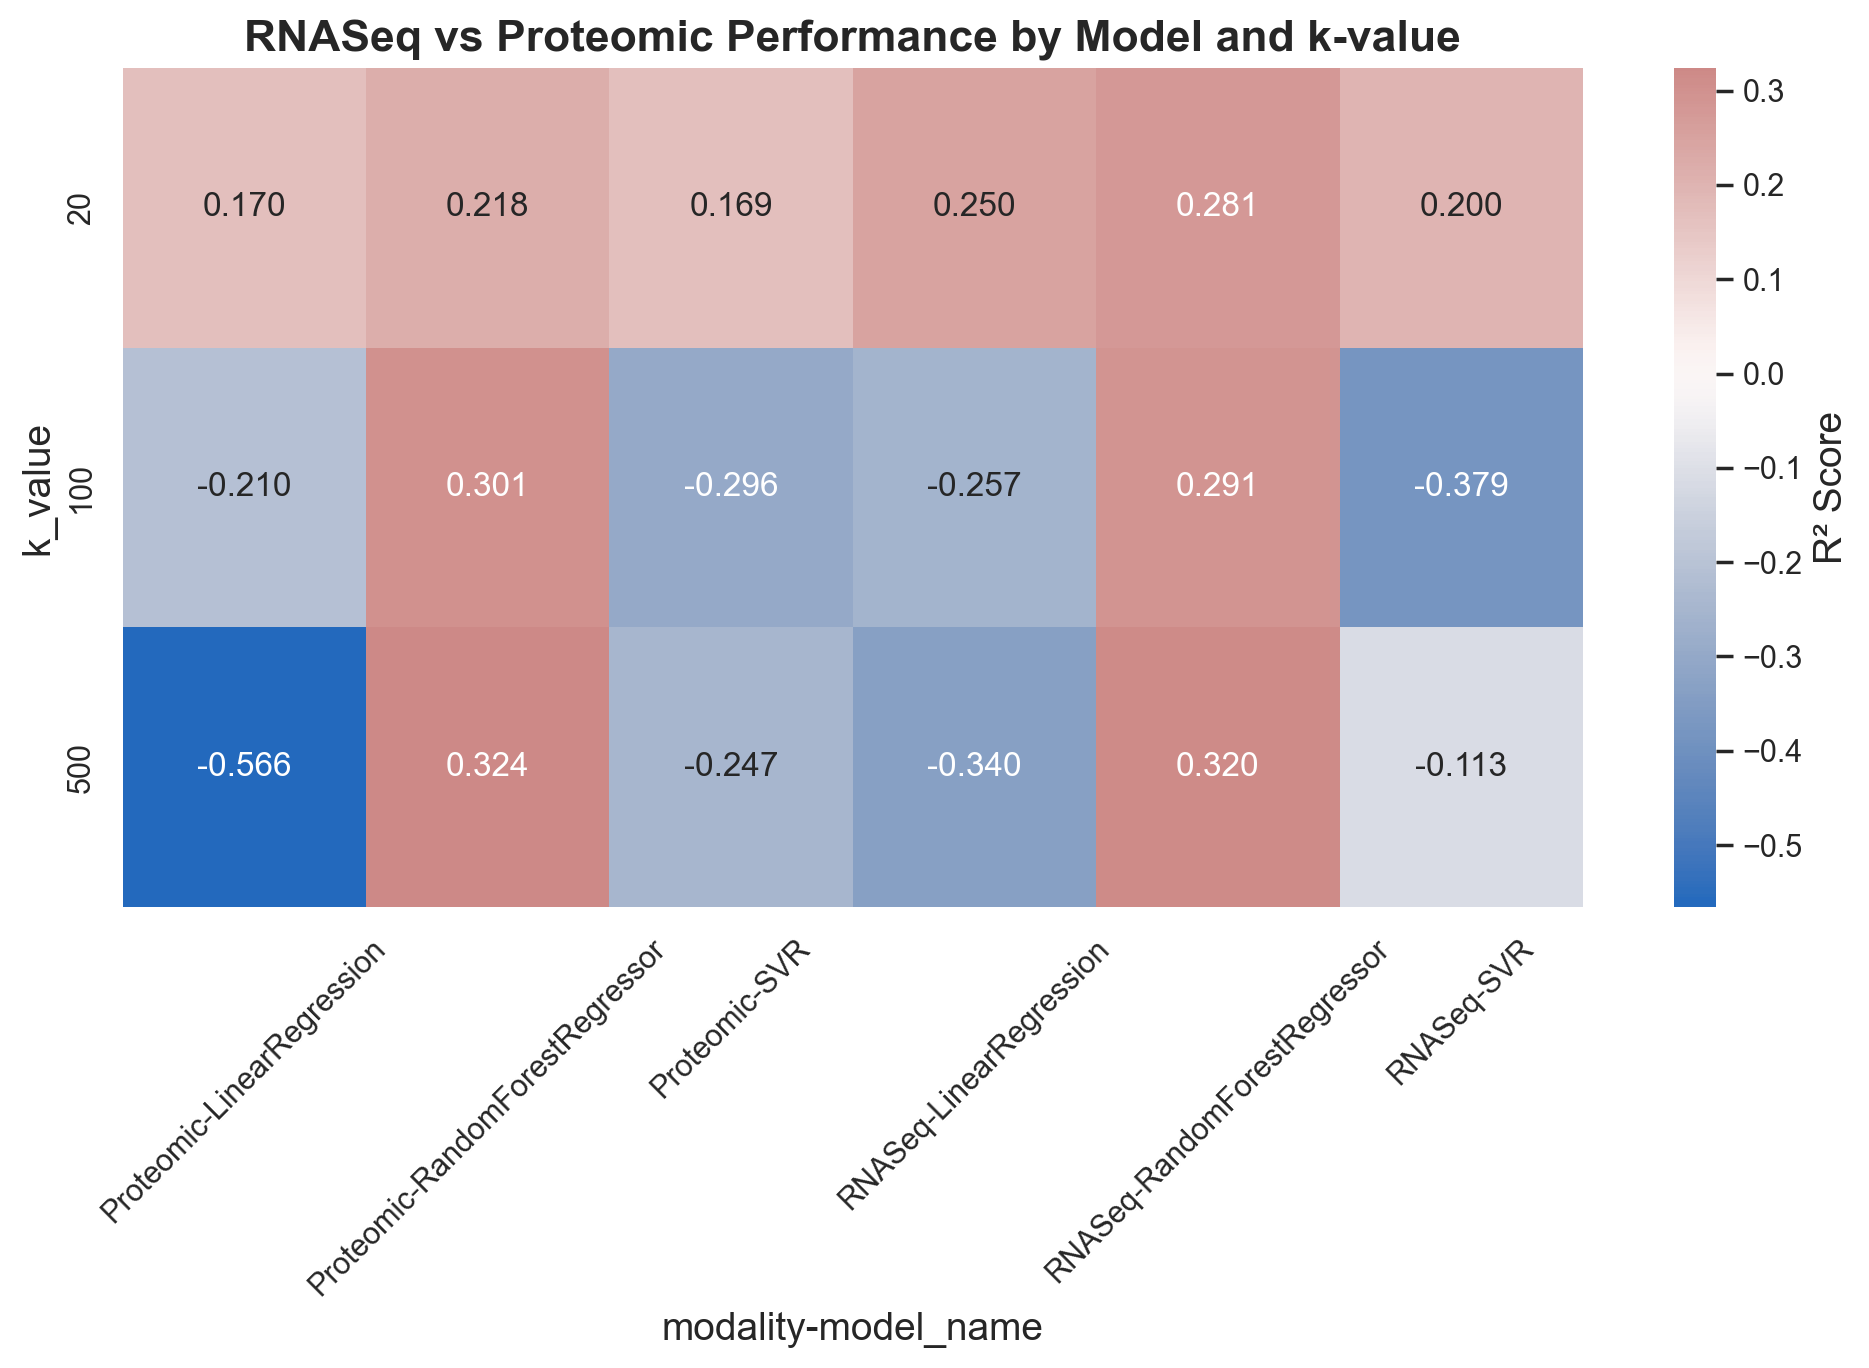

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os  # Added for file path operations

# Improve matplotlib / seaborn defaults for higher-quality figures
plt.rcParams.update({
    "figure.dpi": 200,          # higher on-screen DPI
    # higher DPI when saving
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.titleweight": "bold",
})
sns.set_style("white")
sns.set_context("notebook", rc={"font.size": 12, "axes.titlesize": 16, "axes.labelsize": 14})

# Prepare the data for heatmap
heatmap_data = (
    df_all.groupby(["modality", "model_name", "k_value"])["model_performance"]
    .mean()
    .unstack(["modality", "model_name"])
)

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="vlag",
    center=0,
    cbar_kws={"label": "R² Score"},
)
plt.xticks(rotation=45)
plt.title("RNASeq vs Proteomic Performance by Model and k-value")
plt.tight_layout()

# Save the figure
os.makedirs(file_save_path, exist_ok=True)
fname = os.path.join(file_save_path, "heatmap_performance_comparison.png")
plt.savefig(fname, dpi=300, bbox_inches="tight")
print(f"Saved figure to: {fname}")

# Display the figure
plt.show()

# Optional: Close the figure to free memory
plt.close()

In [14]:
# Save the heatmap figure created from `heatmap_data` to the results folder
os.makedirs(file_save_path, exist_ok=True)
fname = os.path.join(file_save_path, f"heatmap_performance_by_model_k_{exp_id}.png")

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="RdYlBu",
    center=0,
    cbar_kws={"label": "R² Score"},
)
plt.title("RNASeq vs Proteomic Performance by Model and k-value")
plt.tight_layout()
plt.savefig(fname, dpi=300, bbox_inches="tight")
plt.close()

print(f"Saved heatmap to: {fname}")

Saved heatmap to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/heatmap_performance_by_model_k_v1.png


#### Side-by-side Heatmaps

Saved figure to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/direct_comparison_heatmap.png


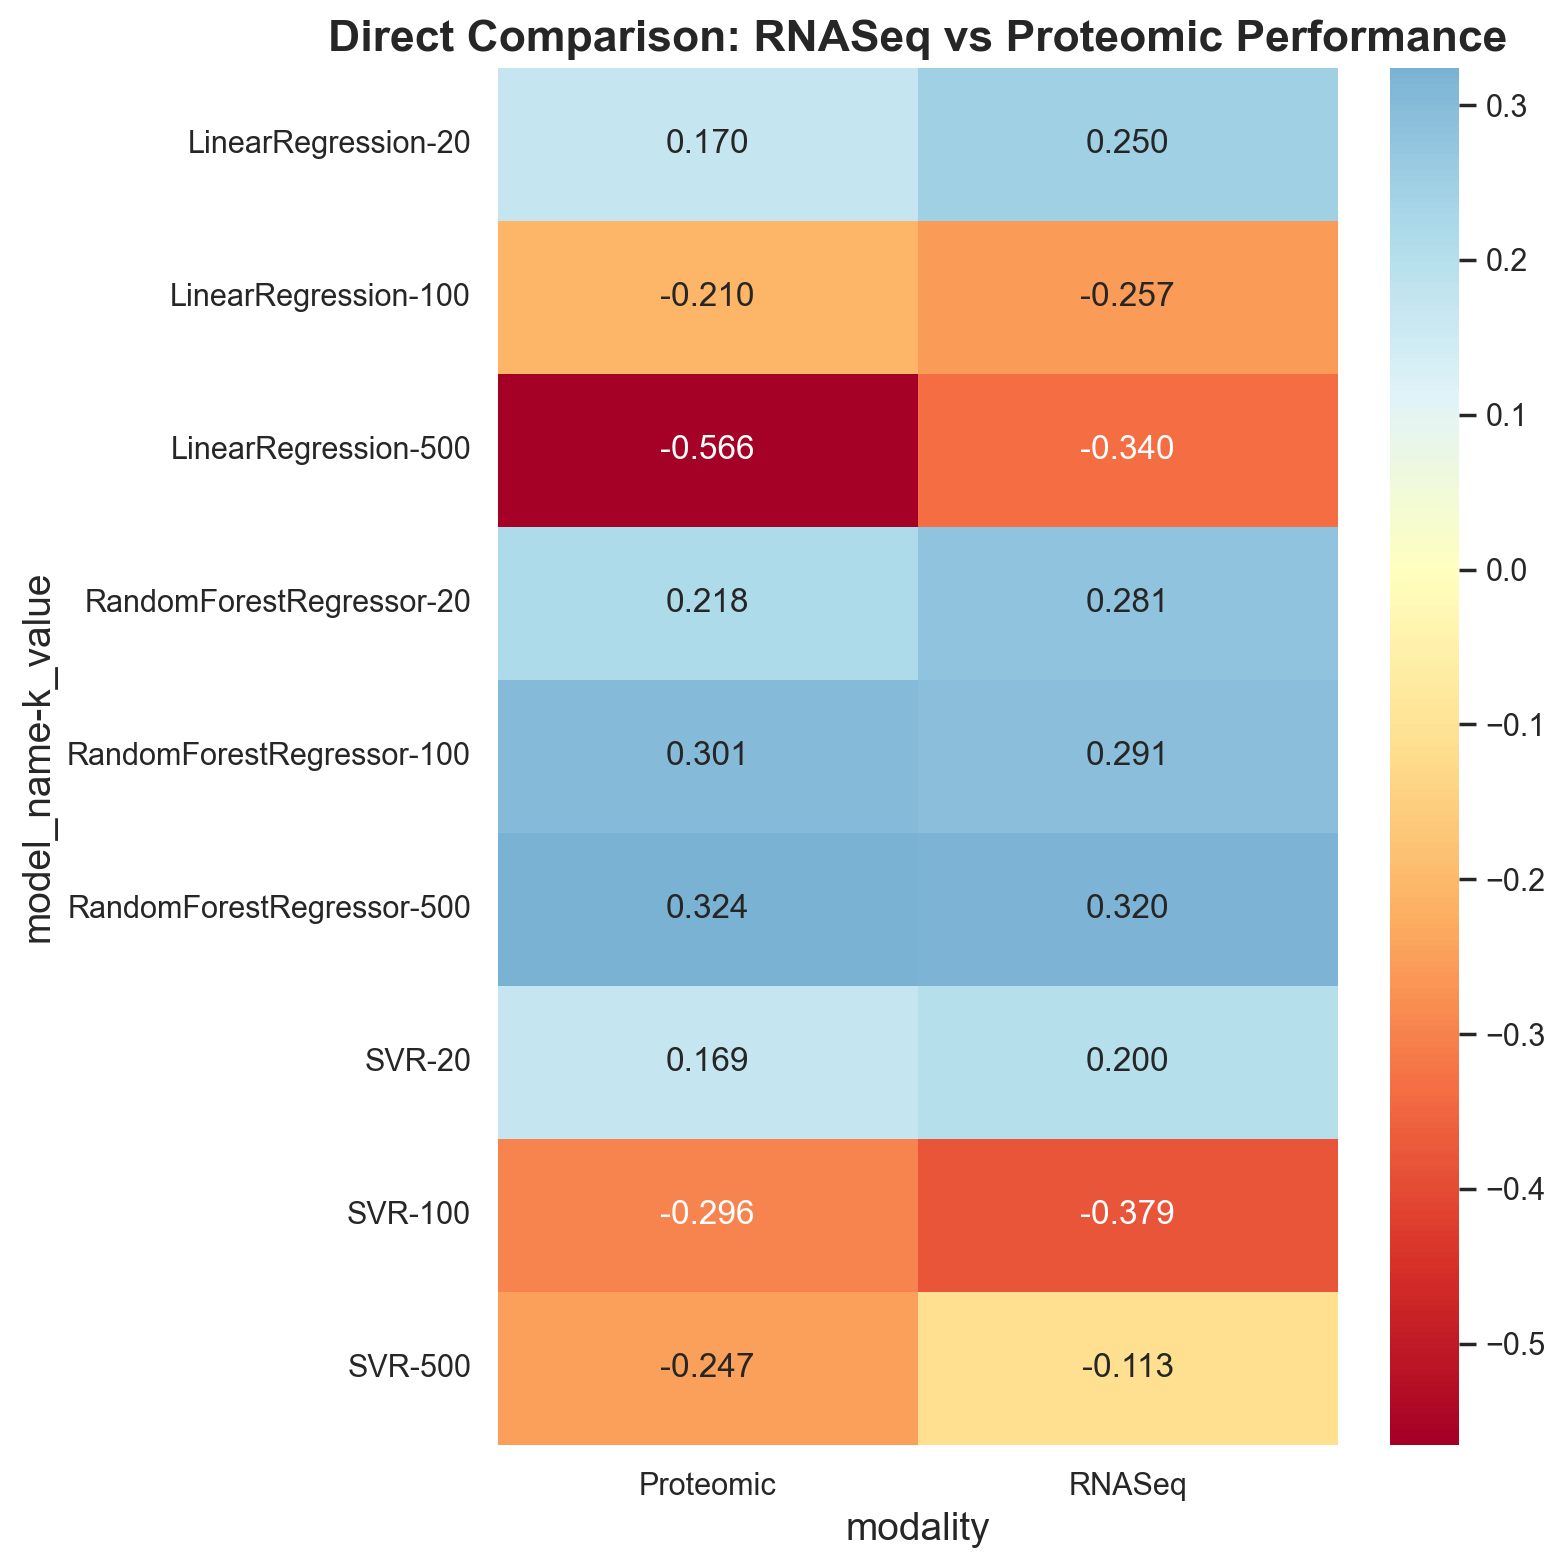

In [34]:
# Create a combined heatmap with modality as columns
pivot_data = df_all.pivot_table(
    index=["model_name", "k_value"],
    columns="modality",
    values="model_performance",
    aggfunc="mean",
).reset_index()
# Set multi-index for better visualization
pivot_data.set_index(["model_name", "k_value"], inplace=True)
plt.figure(figsize=(8, 8))
sns.heatmap(pivot_data, annot=True, fmt=".3f", cmap="RdYlBu", center=0)
plt.title("Direct Comparison: RNASeq vs Proteomic Performance")
plt.tight_layout()

# Save the figure
os.makedirs(file_save_path, exist_ok=True)
fname = os.path.join(file_save_path, "direct_comparison_heatmap.png")
plt.savefig(fname, dpi=300, bbox_inches="tight")
print(f"Saved figure to: {fname}")

# Display the figure
plt.show()

# Optional: Close the figure to free memory
plt.close()


#### Heatmap by diff

Saved figure to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/performance_difference_heatmap_v1.png


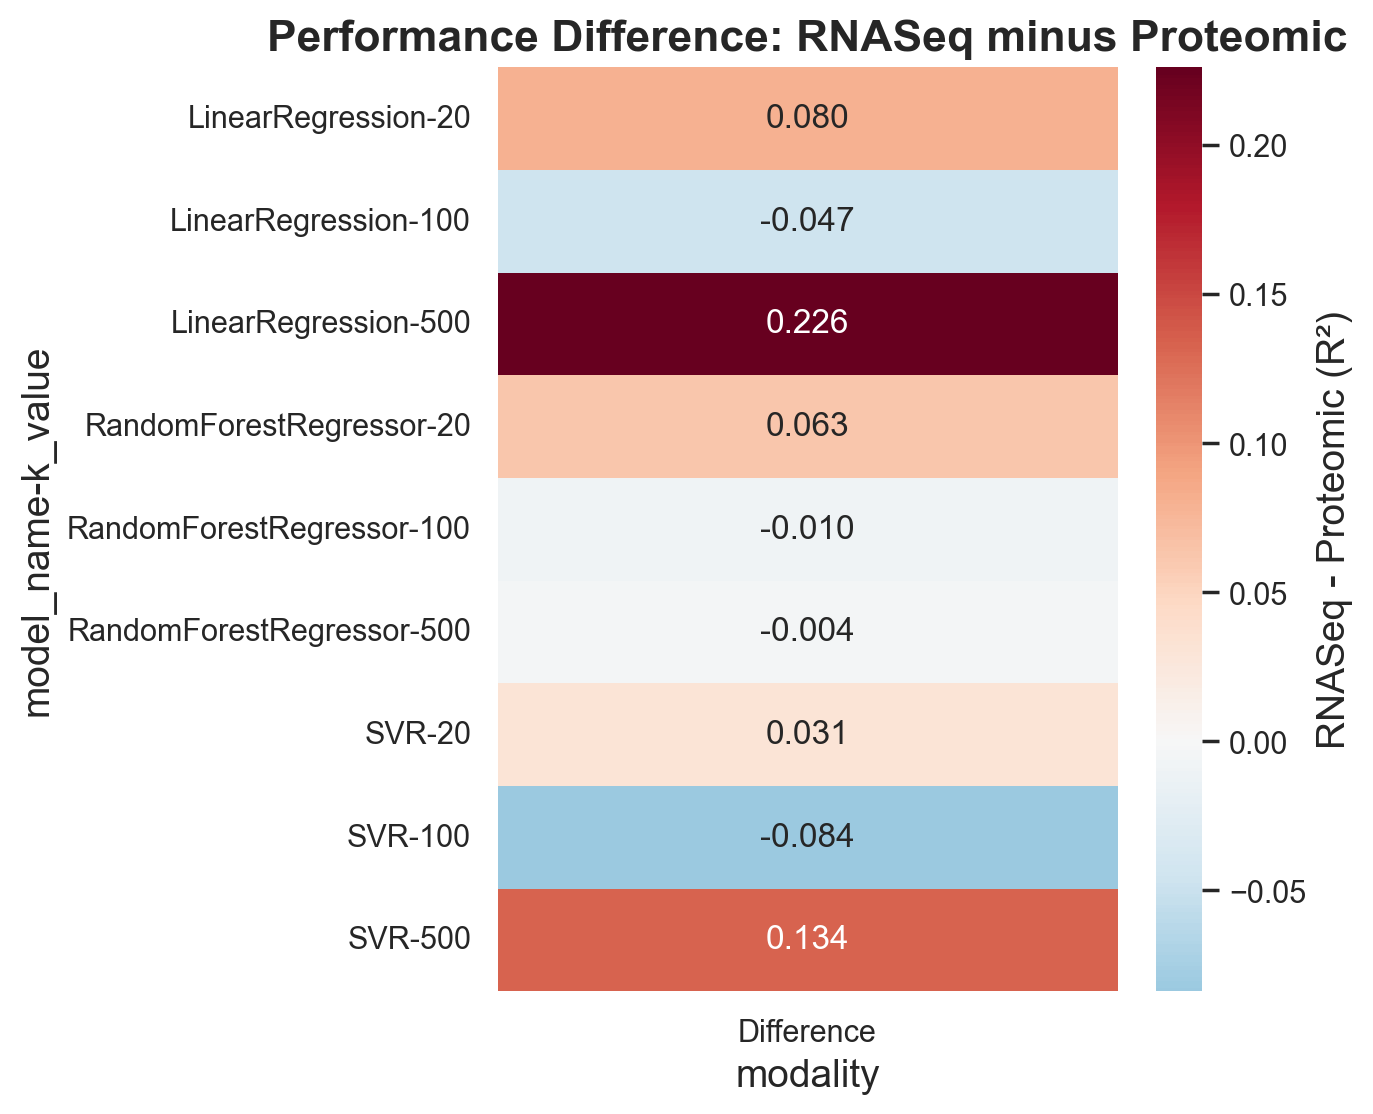

In [36]:
# Calculate performance differences
diff_data = (
    df_all.groupby(["model_name", "k_value", "modality"])["model_performance"]
    .mean()
    .unstack("modality")
)
diff_data["Difference"] = diff_data["RNASeq"] - diff_data["Proteomic"]
plt.figure(figsize=(5, 6))
sns.heatmap(
    diff_data[["Difference"]],
    annot=True,
    fmt=".3f",
    cmap="RdBu_r",
    center=0,
    cbar_kws={"label": "RNASeq - Proteomic (R²)"},
)
plt.title("Performance Difference: RNASeq minus Proteomic")

# Save the figure
os.makedirs(file_save_path, exist_ok=True)
fname = os.path.join(file_save_path, f"performance_difference_heatmap_{exp_id}.png")
plt.savefig(fname, dpi=300, bbox_inches="tight")
print(f"Saved figure to: {fname}")

# Display the figure
plt.show()

# Optional: Close the figure to free memory
plt.close()


### Box Plots

#### Overall comparison

Saved figure to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/modality_comparison_boxenplot_v1.png


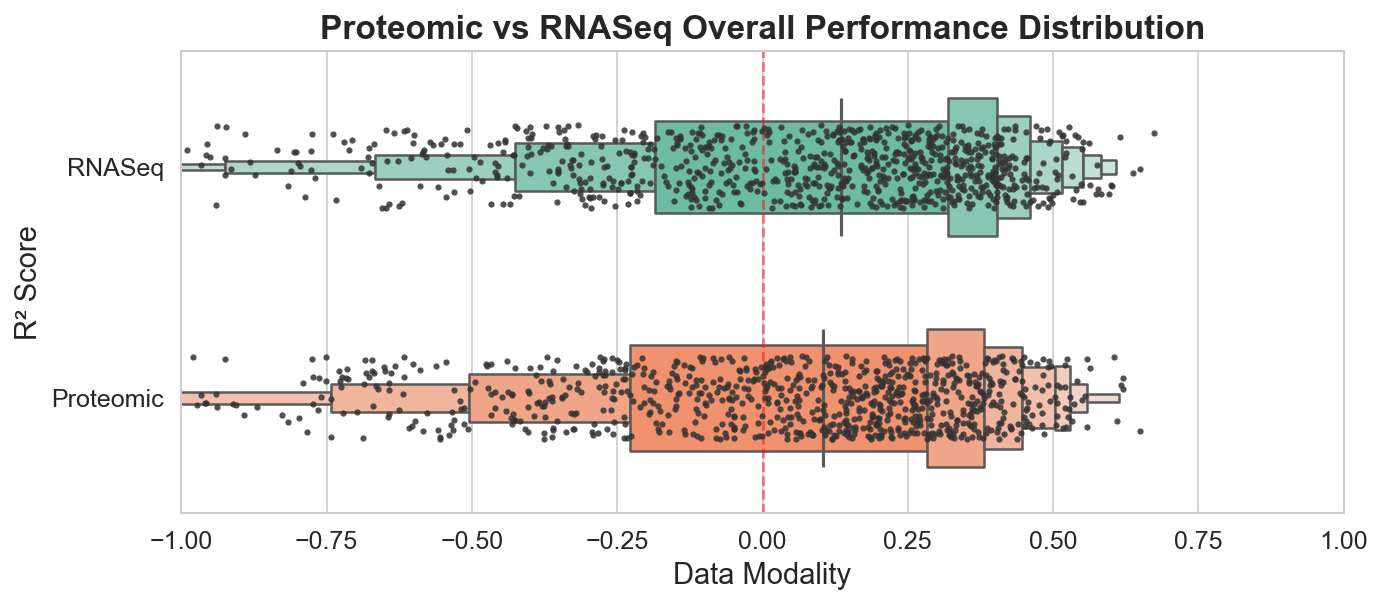

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette(sns.color_palette("Set2"))
# Journal-quality rcParams
plt.rcParams.update(
    {
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "axes.titleweight": "bold",
        "axes.linewidth": 1.0,
        "lines.linewidth": 1.25,
        "legend.frameon": False,
        "grid.color": "#e9ecef",
        "grid.linestyle": "-",
        "grid.linewidth": 0.8,
    }
)
# Seaborn context/style for publication look
sns.set_style("whitegrid")
sns.set_context(
    "paper",
    rc={
        "font.size": 12,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "lines.linewidth": 1.25,
    },
)
sns.set_palette(sns.color_palette("Set2"))
# Tweak default boxplot element appearances (matplotlib accepts these via rcParams)
# Instead of trying to set invalid rcParams keys, pass prop dicts directly to seaborn.boxplot.
boxprops = {"linewidth": 1.2}
flierprops = {
    "marker": "o",
    "markerfacecolor": "white",
    "markeredgecolor": "#333333",
    "markersize": 4,
    "alpha": 0.85,
}
whiskerprops = {"linewidth": 1.0}
capprops = {"linewidth": 1.0}
medianprops = {"linewidth": 1.6, "color": "#222222"}
plt.figure(figsize=(10, 4))
# Use boxenplot (letter-value plot) for better tail/detail than boxplots
sns.boxenplot(
    data=df_all,
    x="model_performance",
    y="modality",
    linewidth=boxprops.get("linewidth", 1.2),
    width=0.6,
    k_depth="trustworthy",
    width_method="area",
    palette="Set2",
    hue='modality',
    saturation=0.85,
    showfliers=False,
    order=["Proteomic", "RNASeq"],
)
# Overlay jittered points to represent individual observations (acts like flierprops)
sns.stripplot(
    data=df_all,
    x="model_performance",
    y="modality",
    color=flierprops.get("markeredgecolor", "#333333"),
    size=3,
    jitter=0.18,
    alpha=flierprops.get("alpha", 0.85),
    edgecolor="white",
)
plt.axvline(x=0, color="red", linestyle="--", alpha=0.5)
plt.xlim(-1, 1.0)
plt.ylim(-0.5, 1.5)
plt.title("Proteomic vs RNASeq Overall Performance Distribution")
plt.ylabel("R² Score")
plt.xlabel("Data Modality")

# Save the figure
os.makedirs(file_save_path, exist_ok=True)
fname = os.path.join(file_save_path, f"modality_comparison_boxenplot_{exp_id}.png")
plt.savefig(fname, dpi=300, bbox_inches="tight")
print(f"Saved figure to: {fname}")

# Display the figure
plt.show()

# Optional: Close the figure to free memory
plt.close()


#### Compare by model type

Saved figure to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/model_modality_comparison_v1.png


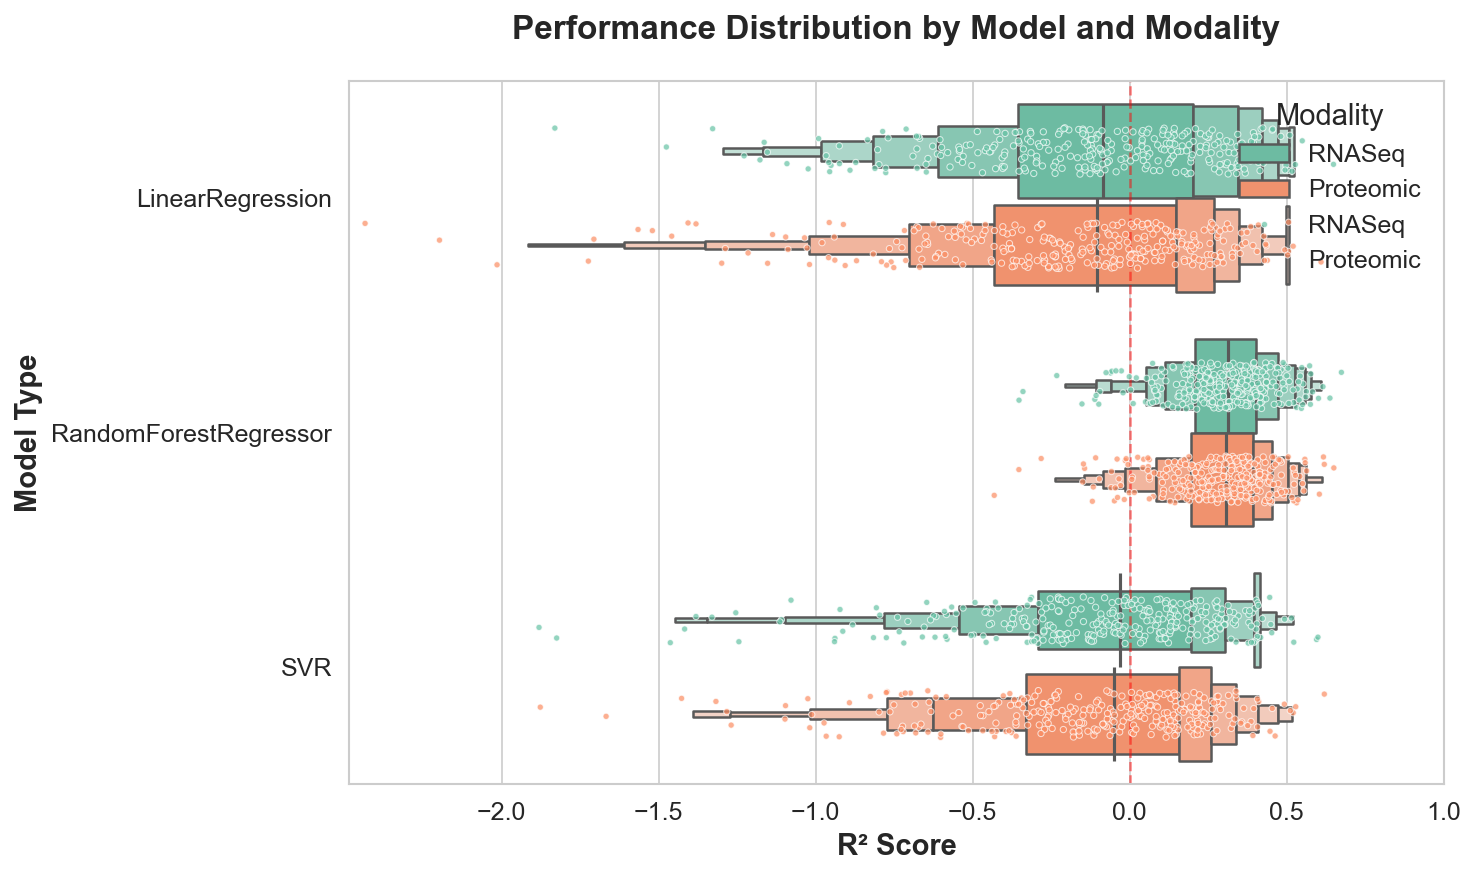

In [61]:
# Compare modalities within each model type with publication-quality styling
plt.figure(figsize=(10, 6))  # Adjusted figure size for horizontal orientation

# Enhanced boxenplot (letter-value plot) with custom styling
sns.boxenplot(
    data=df_all,
    x="model_performance",  # Performance on x-axis (continuous)
    y="model_name",  # Model names on y-axis (categorical)
    hue="modality",
    palette="Set2",
    saturation=0.85,
    linewidth=1.2,
    k_depth="trustworthy",  # Letter-value plot specific parameter
    width_method="area",  # Letter-value plot specific parameter
    showfliers=False,  # boxenplot doesn't use flierprops like boxplot
    order=sorted(df_all["model_name"].unique()),  # Ensure consistent ordering
)

# Overlay individual data points for better transparency
sns.stripplot(
    data=df_all,
    x="model_performance",
    y="model_name",
    hue="modality",
    palette="Set2",
    dodge=True,  # Important: dodges points to align with boxes
    size=3,
    jitter=0.2,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
)

plt.title("Performance Distribution by Model and Modality", fontweight="bold", pad=20)
plt.xlabel("R² Score", fontweight="bold")  # Changed: x-axis is now performance
plt.ylabel("Model Type", fontweight="bold")  # Changed: y-axis is now model names

# Add reference line at x=0 (since performance is now on x-axis)
plt.axvline(x=0, color="red", linestyle="--", alpha=0.5, linewidth=1.2)

# Enhanced legend
plt.legend(
    title="Modality",
    title_fontsize=14,
    fontsize=12,
    frameon=False,
    loc="upper right",  # Added location for better placement
)

# Adjust y-axis if labels are long (since model names are now on y-axis)
if any(len(str(x)) > 10 for x in df_all["model_name"].unique()):
    plt.yticks(rotation=0)  # You can adjust rotation if needed for y-axis labels

# Set appropriate x-axis limits if needed (since performance is now on x-axis)
x_min = df_all["model_performance"].min()
x_max = df_all["model_performance"].max()
plt.xlim(min(-0.1, x_min - 0.05), max(1.0, x_max + 0.05))  # Adjust buffer as needed

plt.tight_layout()

# Save the figure with high quality
os.makedirs(file_save_path, exist_ok=True)
fname = os.path.join(file_save_path, f"model_modality_comparison_{exp_id}.png")
plt.savefig(fname, dpi=300, bbox_inches="tight", facecolor="white")
print(f"Saved figure to: {fname}")

# Display the figure
plt.show()

# Optional: Close the figure to free memory
plt.close()


#### Compare by k value

Saved figure to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/kvalue_modality_comparison_v1.png


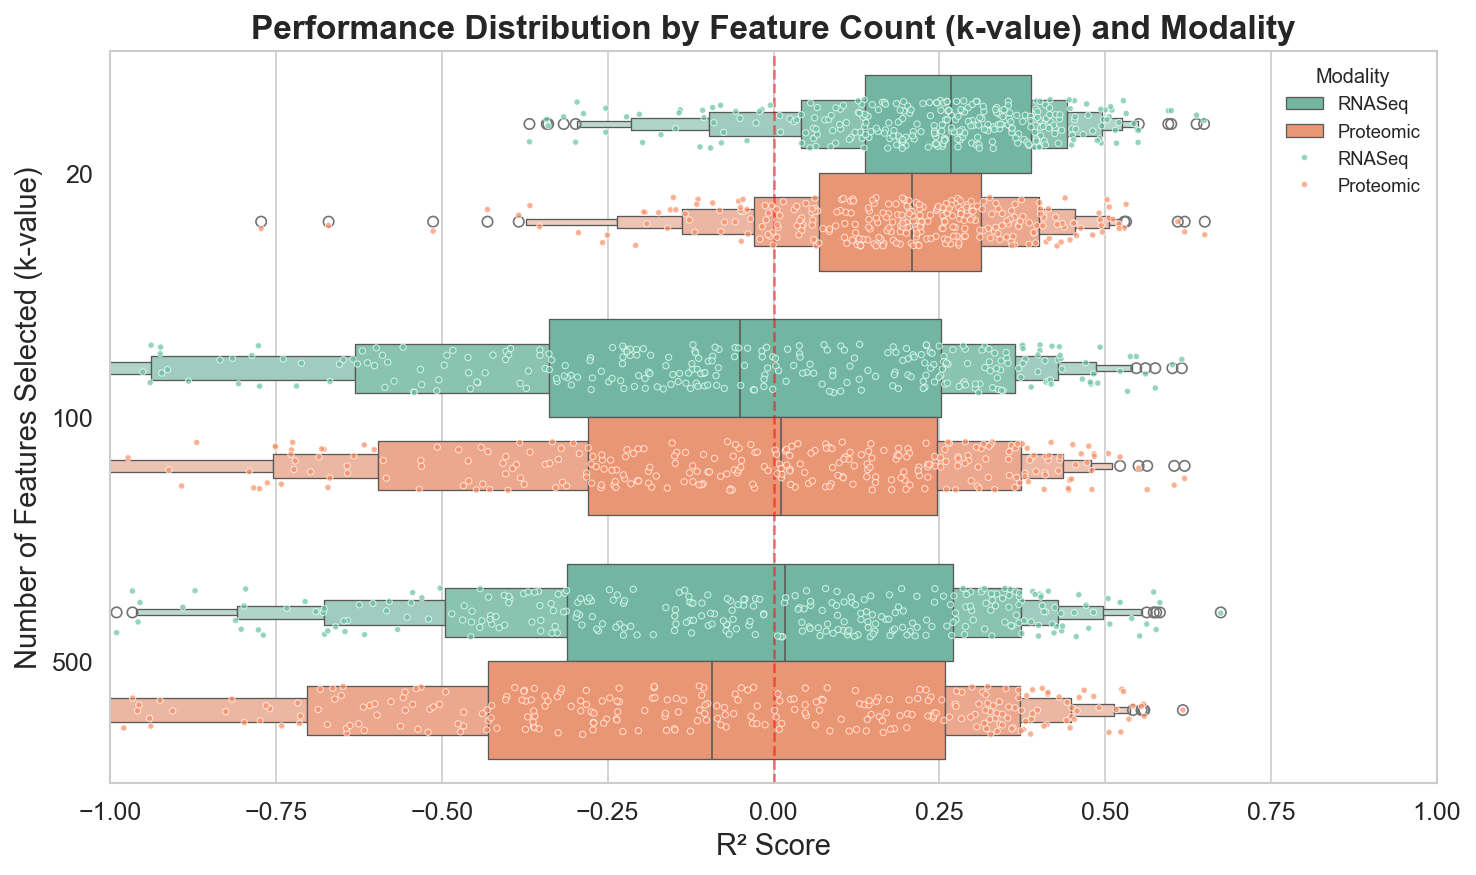

In [69]:
# Compare performance across k-values for each modality
plt.figure(figsize=(10, 6))
sns.boxenplot(
    data=df_all,
    x="model_performance",  # R² Score on x-axis
    y=df_all["k_value"].astype(
        str
    ),  # Convert k_value to string to force categorical treatment
    hue="modality",
    palette="Set2",
)
sns.stripplot(
    data=df_all,
    x="model_performance",
    y=df_all["k_value"].astype(str),
    hue="modality",
    palette="Set2",
    dodge=True,
    size=3,
    jitter=0.2,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
)
plt.xlim(-1, 1.0)
plt.title("Performance Distribution by Feature Count (k-value) and Modality")
plt.xlabel("R² Score")  # Performance on x-axis
plt.ylabel("Number of Features Selected (k-value)")  # k-values on y-axis
plt.axvline(x=0, color="red", linestyle="--", alpha=0.5)  # Vertical line at x=0
plt.legend(title="Modality")
plt.tight_layout()
# Save the figure
os.makedirs(file_save_path, exist_ok=True)
fname = os.path.join(file_save_path, f"kvalue_modality_comparison_{exp_id}.png")
plt.savefig(fname, dpi=300, bbox_inches="tight")
print(f"Saved figure to: {fname}")
# Display the figure
plt.show()
# Optional: Close the figure to free memory
plt.close()


#### Facet Grid

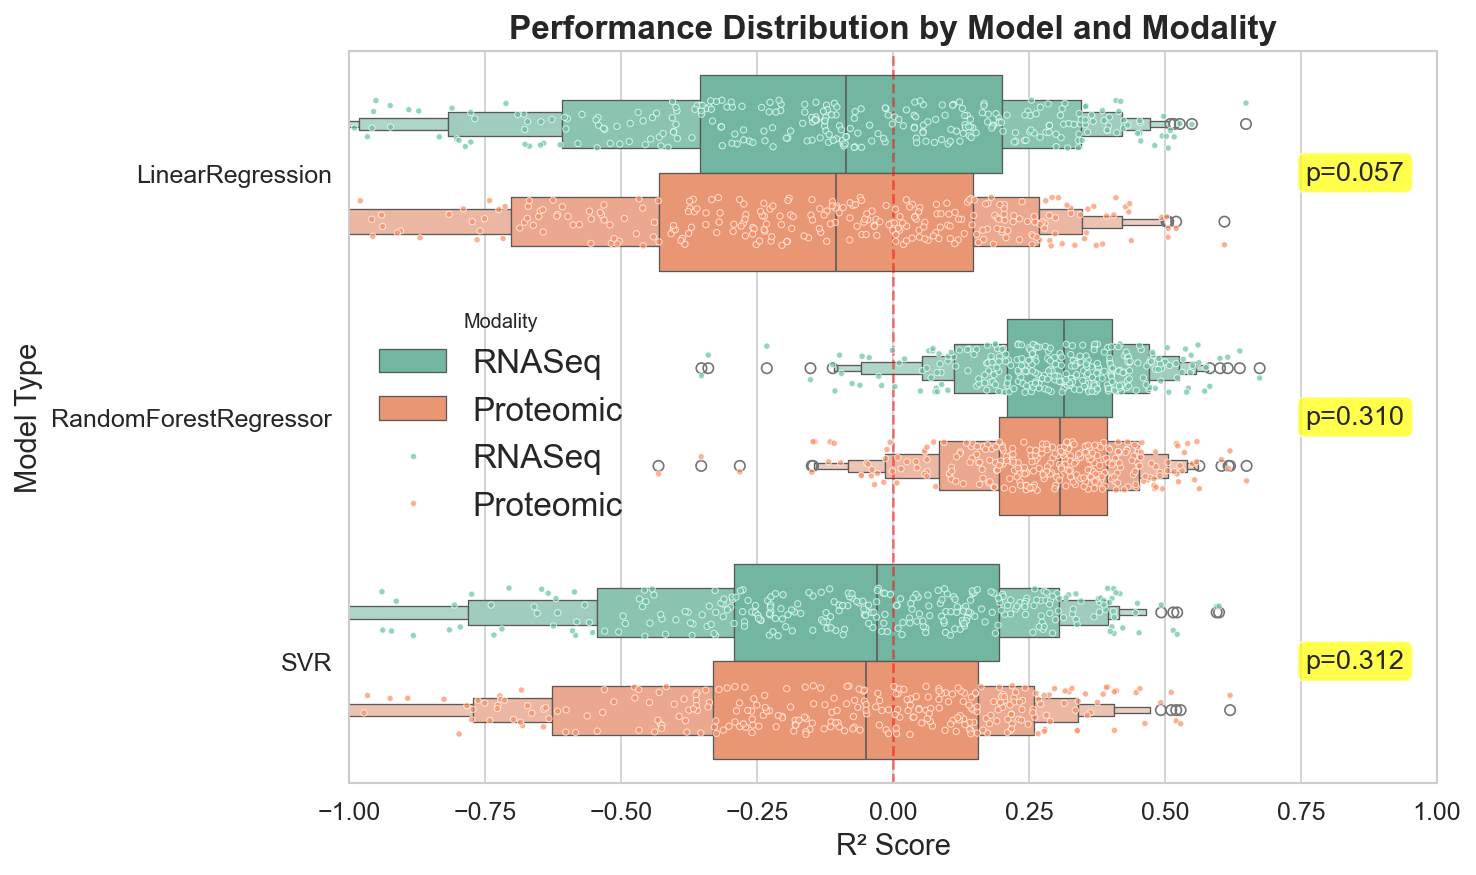

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu

# Compare modalities within each model type with statistics
plt.figure(figsize=(10, 6))
sns.boxenplot(
    data=df_all,
    x="model_performance",  # R² Score on x-axis
    y=df_all["model_name"].astype(
        str
    ),  # Convert model_name to string for categorical treatment
    hue="modality",
    palette="Set2",
)
sns.stripplot(
    data=df_all,
    x="model_performance",
    y=df_all["model_name"].astype(str),
    hue="modality",
    palette="Set2",
    dodge=True,
    size=3,
    jitter=0.2,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
)
plt.xlim(-1, 1.0)
plt.title("Performance Distribution by Model and Modality")
plt.xlabel("R² Score")  # Performance on x-axis
plt.ylabel("Model Type")  # Model names on y-axis
plt.axvline(x=0, color="red", linestyle="--", alpha=0.5)  # Vertical line at x=0
plt.legend(title="Modality", fontsize=16)

# Statistical comparisons for each model
models = df_all["model_name"].unique()
y_positions = range(len(models))  # Get y-axis positions for each model

for i, model in enumerate(models):
    model_data = df_all[df_all["model_name"] == model]
    rna_model = model_data[model_data["modality"] == "RNASeq"]["model_performance"]
    prot_model = model_data[model_data["modality"] == "Proteomic"]["model_performance"]

    # Mann-Whitney test for each model
    _, p_val = mannwhitneyu(rna_model, prot_model, nan_policy="omit")

    # Annotate on the plot - position on x-axis since performance is now horizontal
    plt.text(
        plt.xlim()[1] * 0.85,  # Position at 85% of x-axis range
        i,  # Position at current model's y-level
        f"p={p_val:.3f}",
        ha="center",
        va="center",
        fontsize=13,
        bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7),
    )

plt.tight_layout()
plt.show()


#### Best performer

In [45]:
# Group by modality, model, and k-value to find best performers
performance_comparison = (
    df_all.groupby(["modality", "model_name", "k_value"])["model_performance"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# Find the best model for each modality and k-value combination
best_per_modality_k = performance_comparison.loc[
    performance_comparison.groupby(["modality", "k_value"])["mean"].idxmax()
]

print("Best performing models by modality and k-value:")
print(best_per_modality_k.sort_values(["modality", "k_value"]))


Best performing models by modality and k-value:
     modality             model_name  k_value      mean       std  count
3   Proteomic  RandomForestRegressor       20  0.217957  0.185155    100
4   Proteomic  RandomForestRegressor      100  0.300757  0.156420    100
5   Proteomic  RandomForestRegressor      500  0.323797  0.149243    100
12     RNASeq  RandomForestRegressor       20  0.281002  0.170640    100
13     RNASeq  RandomForestRegressor      100  0.291252  0.165709    100
14     RNASeq  RandomForestRegressor      500  0.319569  0.147476    100


In [46]:
# Create a pivot table for easy comparison
pivot_comparison = df_all.pivot_table(
    index=["model_name", "k_value"],
    columns="modality",
    values="model_performance",
    aggfunc=["mean", "std"],
).round(4)

print("RNASeq vs Proteomic Performance Comparison:")
print(pivot_comparison)


RNASeq vs Proteomic Performance Comparison:
                                   mean               std        
modality                      Proteomic  RNASeq Proteomic  RNASeq
model_name            k_value                                    
LinearRegression      20         0.1703  0.2499    0.2056  0.1976
                      100       -0.2101 -0.2568    0.3513  0.4167
                      500       -0.5656 -0.3395    0.5173  0.3360
RandomForestRegressor 20         0.2180  0.2810    0.1852  0.1706
                      100        0.3008  0.2913    0.1564  0.1657
                      500        0.3238  0.3196    0.1492  0.1475
SVR                   20         0.1692  0.2004    0.2187  0.2016
                      100       -0.2956 -0.3795    0.4067  0.4700
                      500       -0.2470 -0.1131    0.3694  0.2767


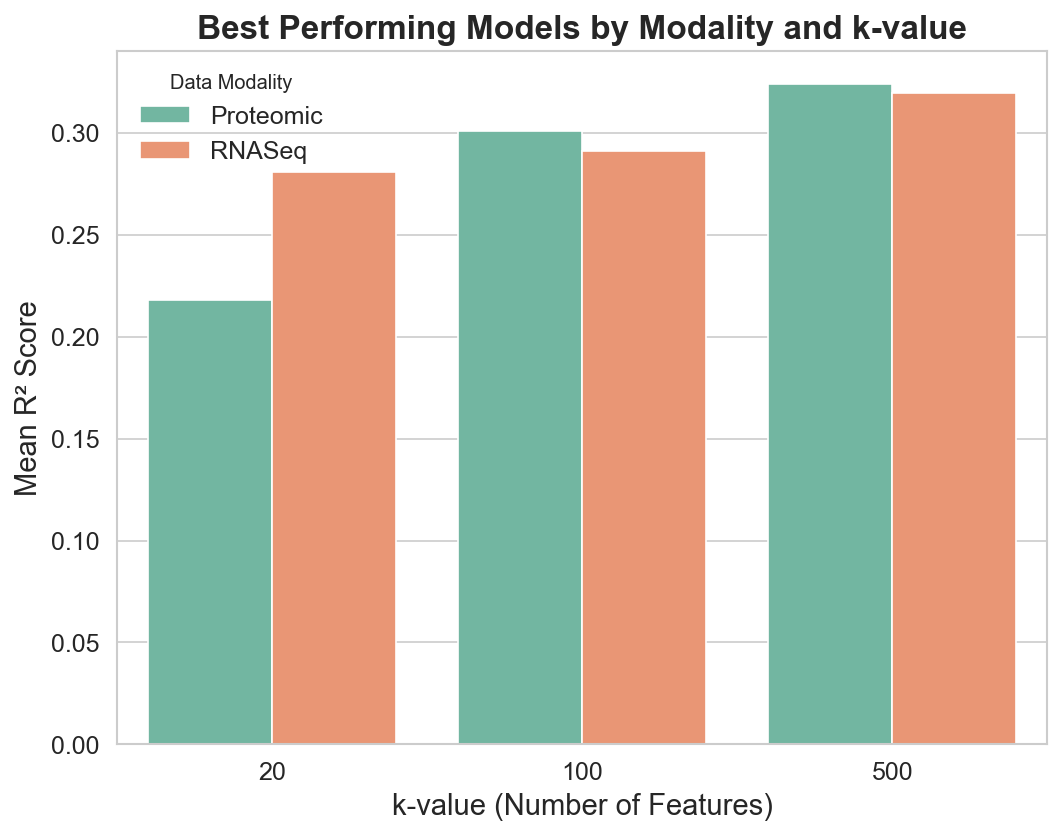

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to show only the best performing combinations
best_models = performance_comparison.groupby(["modality", "k_value"])["mean"].idxmax()
top_performers = performance_comparison.loc[best_models]

plt.figure(figsize=(8, 6))
sns.barplot(data=top_performers, x="k_value", y="mean", hue="modality")
plt.title("Best Performing Models by Modality and k-value")
plt.ylabel("Mean R² Score")
plt.xlabel("k-value (Number of Features)")
plt.legend(title="Data Modality", fontsize=12)
plt.show()


In [51]:
# Compare the best RNASeq vs best Proteomic for each k-value
for k_val in [20, 100, 500]:
    rna_best = df_all[(df_all["modality"] == "RNASeq") & (df_all["k_value"] == k_val)]
    prot_best = df_all[
        (df_all["modality"] == "Proteomic") & (df_all["k_value"] == k_val)
    ]

    # Find best model for this k-value in each modality
    rna_mean = rna_best.groupby("model_name")["model_performance"].mean().max()
    prot_mean = prot_best.groupby("model_name")["model_performance"].mean().max()

    print(
        f"k={k_val}: RNASeq best: {rna_mean:.4f}, Proteomic best: {prot_mean:.4f}, Difference: {rna_mean - prot_mean:.4f}"
    )


k=20: RNASeq best: 0.2810, Proteomic best: 0.2180, Difference: 0.0630
k=100: RNASeq best: 0.2913, Proteomic best: 0.3008, Difference: -0.0095
k=500: RNASeq best: 0.3196, Proteomic best: 0.3238, Difference: -0.0042


### Metrics comparison

#### Extract metrics

In [55]:
# 1) First extract metrics from the dictionary column
if "metrics" in df_all.columns:
    # Unpack the metrics dictionary into separate columns
    metrics_df = pd.json_normalize(df_all["metrics"])
    df_all_extended = df_all.copy()

    # Add the metrics as individual columns
    for col in ["r2", "pearson_r", "spearman_rho"]:
        if col in metrics_df.columns:
            df_all_extended[col] = metrics_df[col]

    # 2) Now calculate correlations between the metrics
    if {"r2", "pearson_r", "spearman_rho"}.issubset(df_all_extended.columns):
        metric_correlations = df_all_extended[
            ["r2", "pearson_r", "spearman_rho"]
        ].corr()
        print("Correlation matrix between evaluation metrics:")
        print(metric_correlations.round(4))

        # Optional: Show some basic statistics
        print("\nMetric summary statistics:")
        print(df_all_extended[["r2", "pearson_r", "spearman_rho"]].describe().round(4))
else:
    print("The 'metrics' column was not found in df_all")


Correlation matrix between evaluation metrics:
                  r2  pearson_r  spearman_rho
r2            1.0000     0.7471        0.6629
pearson_r     0.7471     1.0000        0.9007
spearman_rho  0.6629     0.9007        1.0000

Metric summary statistics:
              r2  pearson_r  spearman_rho
count  1800.0000  1800.0000     1800.0000
mean      0.0065     0.4855        0.4525
std       0.4157     0.1626        0.1749
min      -2.4352    -0.2390       -0.1966
25%      -0.2054     0.3908        0.3376
50%       0.1198     0.5004        0.4664
75%       0.3044     0.6022        0.5781
max       0.6744     0.8610        0.8681


#### Rank consistency

In [57]:
def compare_metric_rankings(df, group_cols=["modality", "condition"]):
    # First extract metrics if needed
    if "metrics" in df.columns and "r2" not in df.columns:
        metrics_df = pd.json_normalize(df["metrics"])
        for col in ["r2", "pearson_r", "spearman_rho"]:
            if col in metrics_df.columns:
                df = df.copy()
                df[col] = metrics_df[col]

    rankings = {}
    for metric in ["r2", "pearson_r", "spearman_rho"]:
        if metric in df.columns:
            # Calculate mean performance by condition
            perf_by_condition = df.groupby(group_cols)[metric].mean()
            # Rank conditions by each metric
            rankings[metric] = perf_by_condition.rank(ascending=False)

    # Compare rankings using Spearman correlation
    if len(rankings) > 1:
        rank_correlations = pd.DataFrame(rankings).corr(method="spearman")
        return rank_correlations
    else:
        return None


# Check if metrics are available as columns first
if (
    any(col in df_all.columns for col in ["r2", "pearson_r", "spearman_rho"])
    or "metrics" in df_all.columns
):
    rank_comparison = compare_metric_rankings(df_all)
    if rank_comparison is not None:
        print("Rank correlation between metrics:")
        print(rank_comparison.round(4))
    else:
        print("Not enough metrics available for rank comparison")
else:
    print("No metric columns found in df_all")


Rank correlation between metrics:
                  r2  pearson_r  spearman_rho
r2            1.0000     0.9649        0.9587
pearson_r     0.9649     1.0000        0.9856
spearman_rho  0.9587     0.9856        1.0000


Saved heatmap to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/rank_correlation_heatmap_v1.png


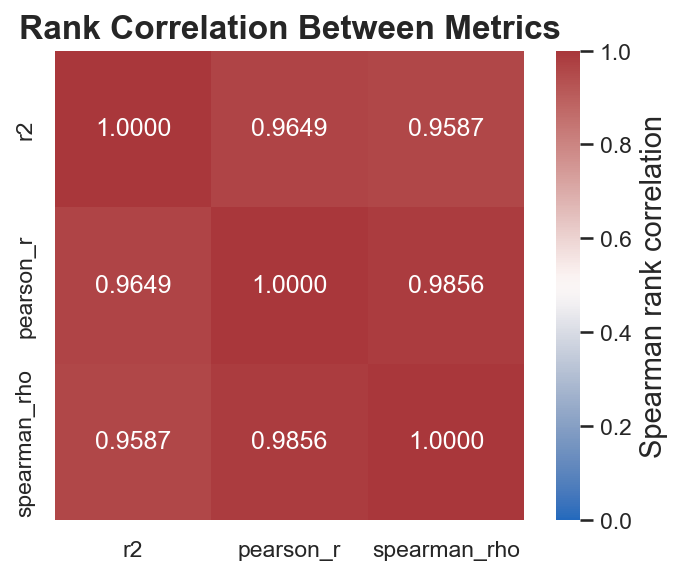

In [76]:
import os

# Heatmap for rank correlation between metrics

corr_values = {
    "r2": [1.0000, 0.9649, 0.9587],
    "pearson_r": [0.9649, 1.0000, 0.9856],
    "spearman_rho": [0.9587, 0.9856, 1.0000],
}
corr_index = ["r2", "pearson_r", "spearman_rho"]

rank_corr_df = pd.DataFrame(corr_values, index=corr_index)[corr_index]

plt.figure(figsize=(5, 4), dpi=150)
sns.heatmap(
    rank_corr_df,
    annot=True,
    fmt=".4f",
    cmap="vlag",
    vmin=0,
    vmax=1.0,
    cbar_kws={"label": "Spearman rank correlation"},
    square=True,
)
plt.title("Rank Correlation Between Metrics")
plt.tight_layout()

os.makedirs(file_save_path, exist_ok=True)
out_fname = os.path.join(file_save_path, f"rank_correlation_heatmap_{exp_id}.png")
plt.savefig(out_fname, dpi=300, bbox_inches="tight")
print(f"Saved heatmap to: {out_fname}")

plt.show()
plt.close()

Saved figure to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult3-BenchmarkingExpressionData/metrics_pairplot_v1.png


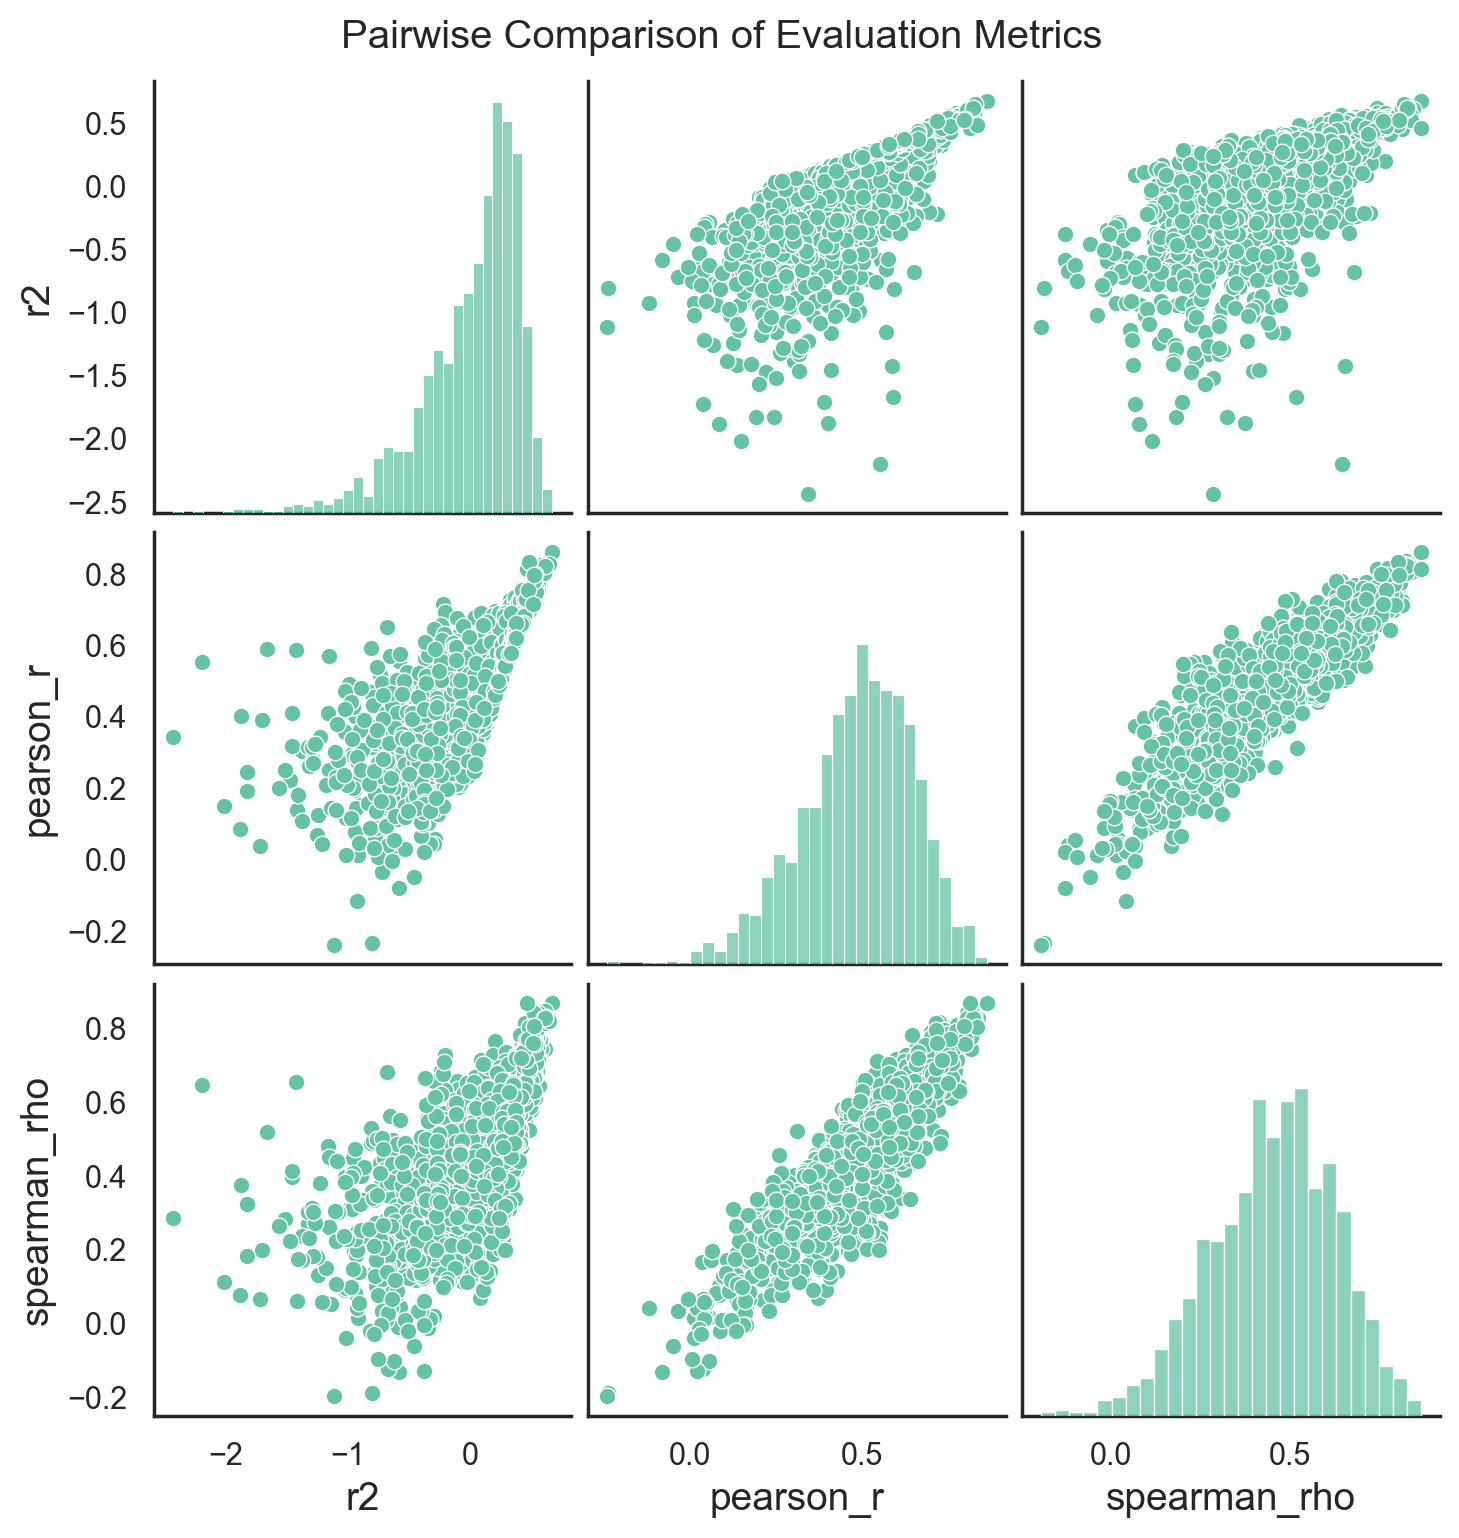

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
if "metrics" in df_all.columns:
    metrics_df = pd.json_normalize(df_all["metrics"])
    plot_data = df_all[["modality", "condition"]].copy()
    for col in ["r2", "pearson_r", "spearman_rho"]:
        if col in metrics_df.columns:
            plot_data[col] = metrics_df[col]
    metrics_to_plot = [
        col for col in ["r2", "pearson_r", "spearman_rho"] if col in plot_data.columns
    ]
    if len(metrics_to_plot) > 1:
        g = sns.pairplot(plot_data[metrics_to_plot], diag_kind="hist")
        g.fig.suptitle("Pairwise Comparison of Evaluation Metrics", y=1.02)

        # Save the figure
        os.makedirs(file_save_path, exist_ok=True)
        fname = os.path.join(file_save_path, f"metrics_pairplot_{exp_id}.png")
        g.savefig(fname, dpi=300, bbox_inches="tight")
        print(f"Saved figure to: {fname}")

        # Display the figure
        plt.show()

        # Optional: Close the figure to free memory
        plt.close()
else:
    print("Cannot create scatter plots: 'metrics' column not found")


#### Condition-level agreement

In [60]:
# Compare metric values across different experimental conditions
if "metrics" in df_all.columns:
    metrics_df = pd.json_normalize(df_all["metrics"])

    # Create temporary columns for analysis
    temp_df = df_all[["modality", "condition"]].copy()
    for col in ["r2", "pearson_r", "spearman_rho"]:
        if col in metrics_df.columns:
            temp_df[col] = metrics_df[col]

    condition_metrics = temp_df.groupby(["modality", "condition"])[
        ["r2", "pearson_r", "spearman_rho"]
    ].mean()

    print("Metric comparison by condition:")
    print(condition_metrics.round(4))

    # Calculate absolute differences between metrics
    if {"r2", "pearson_r"}.issubset(condition_metrics.columns):
        condition_metrics["r2_pearson_diff"] = abs(
            condition_metrics["r2"] - condition_metrics["pearson_r"]
        )

    if {"r2", "spearman_rho"}.issubset(condition_metrics.columns):
        condition_metrics["r2_spearman_diff"] = abs(
            condition_metrics["r2"] - condition_metrics["spearman_rho"]
        )

    print("\nAverage absolute differences between metrics:")
    if "r2_pearson_diff" in condition_metrics.columns:
        print(f"R² vs Pearson r: {condition_metrics['r2_pearson_diff'].mean():.4f}")
    if "r2_spearman_diff" in condition_metrics.columns:
        print(f"R² vs Spearman rho: {condition_metrics['r2_spearman_diff'].mean():.4f}")
else:
    print("Cannot perform condition-level analysis: 'metrics' column not found")


Metric comparison by condition:
                                              r2  pearson_r  spearman_rho
modality  condition                                                      
Proteomic baseline_linearregression_k100 -0.2101     0.3743        0.3470
          baseline_linearregression_k20   0.1703     0.4953        0.4354
          baseline_linearregression_k500 -0.5656     0.3637        0.3442
          baseline_randomforest_k100      0.3008     0.5891        0.5489
          baseline_randomforest_k20       0.2180     0.5297        0.4747
          baseline_randomforest_k500      0.3238     0.6089        0.5739
          baseline_svr_k100              -0.2956     0.3657        0.3311
          baseline_svr_k20                0.1692     0.4996        0.4228
          baseline_svr_k500              -0.2470     0.4198        0.4012
RNASeq    baseline_linearregression_k100 -0.2568     0.3781        0.3695
          baseline_linearregression_k20   0.2499     0.5686        0.5409
      

#### Statistical significance

In [61]:
from scipy.stats import ttest_rel

if "metrics" in df_all.columns:
    metrics_df = pd.json_normalize(df_all["metrics"])

    # Create temporary columns for testing
    test_data = {}
    for col in ["r2", "pearson_r", "spearman_rho"]:
        if col in metrics_df.columns:
            test_data[col] = metrics_df[col].dropna()

    # Perform t-tests for available metric pairs
    if {"r2", "pearson_r"}.issubset(test_data.keys()):
        r2_pearson_ttest = ttest_rel(test_data["r2"], test_data["pearson_r"])
        print(
            f"R² vs Pearson r t-test: statistic={r2_pearson_ttest.statistic:.4f}, p-value={r2_pearson_ttest.pvalue:.4f}"
        )

    if {"r2", "spearman_rho"}.issubset(test_data.keys()):
        r2_spearman_ttest = ttest_rel(test_data["r2"], test_data["spearman_rho"])
        print(
            f"R² vs Spearman rho t-test: statistic={r2_spearman_ttest.statistic:.4f}, p-value={r2_spearman_ttest.pvalue:.4f}"
        )
else:
    print("Cannot perform statistical tests: 'metrics' column not found")


R² vs Pearson r t-test: statistic=-64.8377, p-value=0.0000
R² vs Spearman rho t-test: statistic=-57.8517, p-value=0.0000
